In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from __future__ import print_function
from pandas import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
import pickle
from scipy import stats
import copy
from scipy.stats import entropy
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score

from sklearn.cluster import KMeans

# For statistics. Requires statsmodels 5.0 or more
#from statsmodels.formula.api import ols,gls,wls
# Analysis of Variance (ANOVA) on linear models
#from statsmodels.stats.anova import anova_lm
#tutorial link: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch

(8, 5, 4) (8, 6) (3, 8, 2) (40, 3)


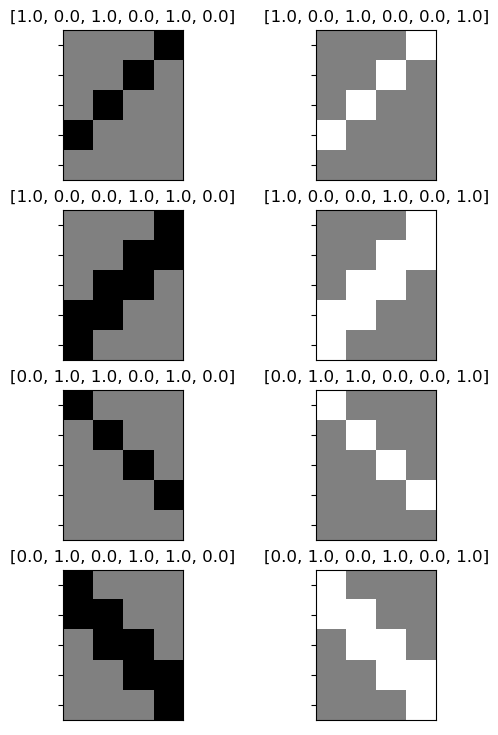

In [4]:
#make dataset
startCondition=[
    [ 0.0, 0.0, 0.0, 0.0,-1.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0,-1.0,-1.0],
    [ 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
    [ 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [ 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [-1.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [ 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
]
X=[]
Y=[]
worldS=[[],[],[]]
worldConcept=[]
figure(figsize=[2,8])
plt.gcf().set_size_inches(6, 10) 
for d in range(2):
    for s in range(2):
        for b in range(2):
            sequence=[]
            condInt=d*4+s*2+b
            currentCondition=startCondition[condInt]
            for steps in range(5):
                row=[0.0,0.0,0.0,0.0]
                for r in range(4):
                    row[r]=currentCondition[r+1]
                if d==0:
                    currentCondition.pop(0)
                    currentCondition.append(0.0)
                else:
                    currentCondition.pop()
                    currentCondition.insert(0,0.0)
                #print(d,s,b,steps,row)
                sequence.append(row)
                worldConcept.append([d,s,b])
            subplot(4,2,condInt+1)
            X.append(copy.deepcopy(sequence))
            answer=[0.0,0.0,0.0,0.0,0.0,0.0]
            answer[d]=1.0
            answer[s+2]=1.0
            answer[b+4]=1.0
            Y.append(answer)
            imshow(sequence,cmap="gray",vmin=-1.0,vmax=1.0)
            #ylim(-0.5,7.5)
            xticks([],[])
            yticks(range(5),[""]*5)
            subplots_adjust(top=0.8)
            title(answer)
            subAd=[0.0,0.0]
            subAd[d]=1.0
            subAs=[0.0,0.0]
            subAs[s]=1.0
            subAb=[0.0,0.0]
            subAb[b]=1.0
            worldS[0].append(subAd)
            worldS[1].append(subAs)
            worldS[2].append(subAb)
    #tight_layout()
X=numpy.array(X)
Y=numpy.array(Y)
worldS=numpy.array(worldS)
worldConcept=numpy.array(worldConcept)
print(X.shape,Y.shape,worldS.shape,worldConcept.shape)

In [5]:
def makeNoisyDataset(X,Y,replicatesPerItem,noise,randomize=True,delayRange=[3]):
    nX=[]
    nY=[]
    nW=[]
    wc=[[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    for n in range(8):
        for i in range(replicatesPerItem):
            dr=numpy.random.choice(delayRange)
            M=numpy.concatenate((X[n],numpy.zeros((int(dr),4))))
            nX.append(M+numpy.random.normal(0.0,noise,(M.shape)))
            nY.append(Y[n])
            nW.append(wc[n])
    #nX=numpy.array(nX)
    nX=numpy.array(nX, dtype=object)
    nY=numpy.array(nY)
    nW=numpy.array(nW)
    if randomize:
        m=8*replicatesPerItem
        order=numpy.random.choice(list(range(m)),(m),replace=False)
        nX=nX[order]
        nY=nY[order]
        nW=nW[numpy.repeat(order,8)]
    nS=[]
    nS.append(nY.transpose()[0:2].transpose())
    nS.append(nY.transpose()[2:4].transpose())
    nS.append(nY.transpose()[4:6].transpose())
    nS=numpy.array(nS)
    return nX,nY,nS,nW 
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,5])
#h=hist(nX.flatten(),linspace(-1.5,1.5,101))
print(nX.shape,nY.shape,nS.shape,nW.shape)

(64,) (64, 6) (3, 64, 2) (512, 3)


In [6]:
def makeNoisyDataset(X,Y,replicatesPerItem,noise,randomize=True,delayRange=[3]):
    nX=[]
    nY=[]
    nW=[]
    wc=[[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    for n in range(8):
        for i in range(replicatesPerItem):
            dr=numpy.random.choice(delayRange)
            M=numpy.concatenate((X[n],numpy.zeros((int(dr),4))))
            nX.append(M+numpy.random.normal(0.0,noise,(M.shape)).astype(numpy.float32)) #explicit cast to numpy.float32
            nY.append(Y[n].astype(numpy.float32))
            nW.append(wc[n])
    nX=numpy.array(nX)
    nY=numpy.array(nY)
    nW=numpy.array(nW)
    if randomize:
        m=8*replicatesPerItem
        order=numpy.random.choice(list(range(m)),(m),replace=False)
        nX=nX[order]
        nY=nY[order]
        nW=nW[numpy.repeat(order,8)]
    nS=[]
    nS.append(nY.transpose()[0:2].transpose())
    nS.append(nY.transpose()[2:4].transpose())
    nS.append(nY.transpose()[4:6].transpose())
    nS=numpy.array(nS)
    return nX,nY,nS,nW 
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,5])
print(nX.shape,nY.shape,nS.shape,nW.shape)

(64,) (64, 6) (3, 64, 2) (512, 3)


C:\Users\enajasa\AppData\Local\Temp\ipykernel_10840\1205567648.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nX=numpy.array(nX)


In [7]:
class Net(nn.Module):
    def __init__(self,hidden_dim=12,output_dim=6):
        super(Net, self).__init__()
        self.rnnLayer=nn.RNN(4,hidden_dim,batch_first=True)
        self.outputLayer=nn.Linear(hidden_dim,output_dim)
        self.hidden_dim=hidden_dim
        self.resetHidden()
        
    def resetHidden(self):
        self.hidden=list()
        
    def forward(self, x,return_activations=False):
        self.h0=torch.Tensor(numpy.zeros((1,x.shape[0],self.hidden_dim)))
        out,self.h0=self.rnnLayer(x,self.h0)
        out=torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out=torch.sigmoid(self.outputLayer(out[:, -1, :]))
        if return_activations:
            activations = out.detach().numpy()
            return out, activations
        return out
    

    
    def step(self,x):
        O=[]
        H=[]
        for l in range(x.shape[0]):
            h0=torch.Tensor(numpy.zeros((1,1,self.hidden_dim)))
            for i in range(x.shape[1]):
                out,h0=self.rnnLayer(x[l][i].reshape((1,1,4)),h0)
                H.append(out.detach().numpy().flatten())
            out=torch.tanh(out)
            out=torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O),numpy.array(H)
    
model=Net()

    

In [8]:
def test(model,X=X,Y=Y,S=worldS):
    model.resetHidden()
    output=model(torch.Tensor(X))
    O=1.0*(output.detach().numpy()>0.5)
    subA=[]
    antiA=[]
    for i in range(3):
        sY=O.transpose()[(i*2):(i*2)+2].transpose()
        subA.append((1.0*(sY==S[i])).mean())
        antiA.append((1.0*(sY==(1.0-S[i]))).mean())
    totalAcc=(1.0*(O==Y)).mean()
    return totalAcc,subA,antiA

model=Net(hidden_dim=12,output_dim=6)
#model.load_state_dict(torch.load("fullModel.model"))
print("full model:",test(model))

full model: (0.5, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])


In [9]:
import matplotlib.pyplot as plt

delay_ranges = [[1],[2],[3],[4],[5]]
#delay_ranges = [[3]]
num_replicates = 5
models = {}

for delayRange in delay_ranges:
    print(f"Training for delay range {delayRange}...")
    all_w = []

    for replicate in range(num_replicates):
        model=Net(hidden_dim=12,output_dim=6)
        optimizer = optim.Adam(model.parameters(),lr=0.001)
        error = nn.MSELoss()
        acc=0.0
        W=[]
        Ts=[]
        iteration_list = []
        loss_list = []
        accuracy_list = []

        while acc<0.97:
            divs=[]
            model.resetHidden()
            nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=delayRange) #variance for the ND is 0.2
            for i in range(nX.shape[0]): #use 64 when training for single delayRange
                optimizer.zero_grad()
                output = model(torch.Tensor(nX[i].reshape(1,nX[i].shape[0],4))) #shape greater than 8
                loss = error(output, torch.Tensor(nY[i]))
                loss.backward()
                optimizer.step()
                div=output.detach().numpy().reshape(nY[i].shape)-nY[i]
                divs.append(1.0-abs(div).mean())
                current_iteration = len(iteration_list) + 1
                loss_list.append(loss.item())
                iteration_list.append(current_iteration)
                accuracy_list.append(mean(divs))

            acc=mean(divs)
            W.append(acc)
            total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
            Ts.append(subA)
            print(f"Iteration: {current_iteration}, Loss: {loss.item()}, Accuracy: {accuracy_list[-1]}")

        model_name = f"fullModel_dr{delayRange}_replicate{replicate}.model"
        torch.save(model.state_dict(), model_name)
        print(f"Saved {model_name}")
        models[model_name] = model

        W_name = f"W_dr{delayRange}_replicate{replicate}.p"
        with open(W_name, "wb") as f:
            pickle.dump(W, f)
        print(f"Saved {W_name}")

        w=[]
        for tr in delayRange:
            nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[tr])
            total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
            print(tr,total,subA)
            w.append(total)

        all_w.append(w)
        w_name = f"w_dr{delayRange}_replicate{replicate}.p"
        with open(w_name, "wb") as f:
            pickle.dump(w, f)
        print(f"Saved {w_name}")

        print(f"Replicate {replicate} completed")
        print(f"Time elapsed: {time.process_time()} seconds")




Training for delay range [1]...
Iteration: 64, Loss: 0.2329576015472412, Accuracy: 0.5000205594114959
Iteration: 128, Loss: 0.24711187183856964, Accuracy: 0.5058715352788568
Iteration: 192, Loss: 0.20822246372699738, Accuracy: 0.528904743026942


C:\Users\enajasa\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 256, Loss: 0.16070376336574554, Accuracy: 0.5695213032886386
Iteration: 320, Loss: 0.1605972945690155, Accuracy: 0.5986245041713119
Iteration: 384, Loss: 0.18172180652618408, Accuracy: 0.6146705034188926
Iteration: 448, Loss: 0.1814524531364441, Accuracy: 0.6246015280485153
Iteration: 512, Loss: 0.16735027730464935, Accuracy: 0.6317236805334687
Iteration: 576, Loss: 0.1740981489419937, Accuracy: 0.6358052925206721
Iteration: 640, Loss: 0.17236952483654022, Accuracy: 0.6390325743705034
Iteration: 704, Loss: 0.17119288444519043, Accuracy: 0.642227596603334
Iteration: 768, Loss: 0.1696958690881729, Accuracy: 0.6442772522568703
Iteration: 832, Loss: 0.1755843162536621, Accuracy: 0.6459627151489258
Iteration: 896, Loss: 0.1728333979845047, Accuracy: 0.6481377412565053
Iteration: 960, Loss: 0.17190460860729218, Accuracy: 0.6495170276612043
Iteration: 1024, Loss: 0.17484454810619354, Accuracy: 0.6511294385418296
Iteration: 1088, Loss: 0.17278309166431427, Accuracy: 0.65373621368780

Iteration: 7616, Loss: 0.03109603188931942, Accuracy: 0.9017489622347057
Iteration: 7680, Loss: 0.00401992816478014, Accuracy: 0.8965119005297311
Iteration: 7744, Loss: 0.023385822772979736, Accuracy: 0.8998621221981011
Iteration: 7808, Loss: 0.002667047781869769, Accuracy: 0.9003471003379673
Iteration: 7872, Loss: 0.026475833728909492, Accuracy: 0.89930704026483
Iteration: 7936, Loss: 0.06743329763412476, Accuracy: 0.9019552386598662
Iteration: 8000, Loss: 0.009348924271762371, Accuracy: 0.9096319723757915
Iteration: 8064, Loss: 0.06001637503504753, Accuracy: 0.9076273019891232
Iteration: 8128, Loss: 0.024687601253390312, Accuracy: 0.909511142061092
Iteration: 8192, Loss: 0.004238925874233246, Accuracy: 0.9083854542113841
Iteration: 8256, Loss: 0.011214536614716053, Accuracy: 0.9059166187071241
Iteration: 8320, Loss: 0.011831424199044704, Accuracy: 0.9112340293941088
Iteration: 8384, Loss: 0.034876950085163116, Accuracy: 0.9162799925543368
Iteration: 8448, Loss: 0.005709609482437372, 

Iteration: 640, Loss: 0.15892751514911652, Accuracy: 0.645891067571938
Iteration: 704, Loss: 0.16580362617969513, Accuracy: 0.6464267144910991
Iteration: 768, Loss: 0.1806427389383316, Accuracy: 0.6480990936979651
Iteration: 832, Loss: 0.1621657758951187, Accuracy: 0.6502175726927817
Iteration: 896, Loss: 0.15626958012580872, Accuracy: 0.6510979747399688
Iteration: 960, Loss: 0.17567472159862518, Accuracy: 0.65168726304546
Iteration: 1024, Loss: 0.17764264345169067, Accuracy: 0.6524383081123233
Iteration: 1088, Loss: 0.15702684223651886, Accuracy: 0.651905641425401
Iteration: 1152, Loss: 0.18004494905471802, Accuracy: 0.6545542129315436
Iteration: 1216, Loss: 0.16619937121868134, Accuracy: 0.6544940648600459
Iteration: 1280, Loss: 0.1622616946697235, Accuracy: 0.6549255885183811
Iteration: 1344, Loss: 0.1564081907272339, Accuracy: 0.6544824801385403
Iteration: 1408, Loss: 0.16179214417934418, Accuracy: 0.6544504044577479
Iteration: 1472, Loss: 0.1564452201128006, Accuracy: 0.6571216722

Iteration: 7936, Loss: 0.02965199388563633, Accuracy: 0.9291010729211848
Iteration: 8000, Loss: 0.006359373684972525, Accuracy: 0.9305115730385296
Iteration: 8064, Loss: 0.005140676628798246, Accuracy: 0.9363579786149785
Iteration: 8128, Loss: 0.010525867342948914, Accuracy: 0.9366144078085199
Iteration: 8192, Loss: 0.0022668945603072643, Accuracy: 0.9432191490777768
Iteration: 8256, Loss: 0.0021382097620517015, Accuracy: 0.9411909665795974
Iteration: 8320, Loss: 0.006837157066911459, Accuracy: 0.9400869050004985
Iteration: 8384, Loss: 0.005101060029119253, Accuracy: 0.9447248033538926
Iteration: 8448, Loss: 0.007359800394624472, Accuracy: 0.9440435784345027
Iteration: 8512, Loss: 0.001555409631691873, Accuracy: 0.9450283041514922
Iteration: 8576, Loss: 0.005106107797473669, Accuracy: 0.9441444921831135
Iteration: 8640, Loss: 0.005031183827668428, Accuracy: 0.9491087319620419
Iteration: 8704, Loss: 0.11483118683099747, Accuracy: 0.9346296677540522
Iteration: 8768, Loss: 0.0049295150674

Iteration: 3648, Loss: 0.15790842473506927, Accuracy: 0.6625572936609387
Iteration: 3712, Loss: 0.1553986370563507, Accuracy: 0.6655598552897573
Iteration: 3776, Loss: 0.17780788242816925, Accuracy: 0.6661974531598389
Iteration: 3840, Loss: 0.15945129096508026, Accuracy: 0.6673559974879026
Iteration: 3904, Loss: 0.15735723078250885, Accuracy: 0.6668783985078335
Iteration: 3968, Loss: 0.15853624045848846, Accuracy: 0.669552213512361
Iteration: 4032, Loss: 0.17481154203414917, Accuracy: 0.6700857589021325
Iteration: 4096, Loss: 0.14702358841896057, Accuracy: 0.6714569684118032
Iteration: 4160, Loss: 0.14973367750644684, Accuracy: 0.6747555234469473
Iteration: 4224, Loss: 0.15534399449825287, Accuracy: 0.676021627150476
Iteration: 4288, Loss: 0.15940441191196442, Accuracy: 0.6769037232734263
Iteration: 4352, Loss: 0.12021518498659134, Accuracy: 0.6817984986118972
Iteration: 4416, Loss: 0.13937515020370483, Accuracy: 0.6835198067128658
Iteration: 4480, Loss: 0.14114414155483246, Accuracy: 

Iteration: 10816, Loss: 0.006933063734322786, Accuracy: 0.9445606287335977
Iteration: 10880, Loss: 0.0022930775303393602, Accuracy: 0.9543298958160449
Iteration: 10944, Loss: 0.0011532852659001946, Accuracy: 0.9498894819698762
Iteration: 11008, Loss: 0.0205692108720541, Accuracy: 0.9524100504058879
Iteration: 11072, Loss: 0.0010418700985610485, Accuracy: 0.9498884893255308
Iteration: 11136, Loss: 0.00305210635997355, Accuracy: 0.9489266396558378
Iteration: 11200, Loss: 0.0014144674642011523, Accuracy: 0.9454386466240976
Iteration: 11264, Loss: 0.0036902192514389753, Accuracy: 0.950005546445027
Iteration: 11328, Loss: 0.003454013727605343, Accuracy: 0.959126809873851
Iteration: 11392, Loss: 0.004689928609877825, Accuracy: 0.9385093878954649
Iteration: 11456, Loss: 0.0008463312988169491, Accuracy: 0.9521359457576182
Iteration: 11520, Loss: 0.005906419828534126, Accuracy: 0.9552927390614059
Iteration: 11584, Loss: 0.0027828195597976446, Accuracy: 0.9580380569968838
Iteration: 11648, Loss:

Iteration: 4928, Loss: 0.10365218669176102, Accuracy: 0.7545927793253213
Iteration: 4992, Loss: 0.11436798423528671, Accuracy: 0.7563153924420476
Iteration: 5056, Loss: 0.10012602061033249, Accuracy: 0.7566137367393821
Iteration: 5120, Loss: 0.06942237913608551, Accuracy: 0.7567596787121147
Iteration: 5184, Loss: 0.07086598873138428, Accuracy: 0.7691727371420711
Iteration: 5248, Loss: 0.12734389305114746, Accuracy: 0.7653907295316458
Iteration: 5312, Loss: 0.12206030637025833, Accuracy: 0.7687530270777643
Iteration: 5376, Loss: 0.11677303165197372, Accuracy: 0.7724628506693989
Iteration: 5440, Loss: 0.055017706006765366, Accuracy: 0.7711248963605613
Iteration: 5504, Loss: 0.09061533212661743, Accuracy: 0.7712450944818556
Iteration: 5568, Loss: 0.11742138862609863, Accuracy: 0.7725051348097622
Iteration: 5632, Loss: 0.058955952525138855, Accuracy: 0.76970727997832
Iteration: 5696, Loss: 0.1096753478050232, Accuracy: 0.7780155863147229
Iteration: 5760, Loss: 0.10816207528114319, Accuracy

Iteration: 12096, Loss: 0.0019212925108149648, Accuracy: 0.8796734974021092
Iteration: 12160, Loss: 0.0736701488494873, Accuracy: 0.8824833665566985
Iteration: 12224, Loss: 0.0029368968680500984, Accuracy: 0.8839767136669252
Iteration: 12288, Loss: 0.09842904657125473, Accuracy: 0.8820323775580619
Iteration: 12352, Loss: 0.006741931661963463, Accuracy: 0.8866506880149245
Iteration: 12416, Loss: 0.06390071660280228, Accuracy: 0.8821459606115241
Iteration: 12480, Loss: 0.0761837363243103, Accuracy: 0.8753650404687505
Iteration: 12544, Loss: 0.09146595001220703, Accuracy: 0.8832437231030781
Iteration: 12608, Loss: 0.09904059767723083, Accuracy: 0.8806077265180647
Iteration: 12672, Loss: 0.05712135136127472, Accuracy: 0.8807133218506351
Iteration: 12736, Loss: 0.07376234978437424, Accuracy: 0.8769620112725534
Iteration: 12800, Loss: 0.06647535413503647, Accuracy: 0.883775215188507
Iteration: 12864, Loss: 0.05547553673386574, Accuracy: 0.8851196379109751
Iteration: 12928, Loss: 0.1023683249

Iteration: 19136, Loss: 0.0010394483106210828, Accuracy: 0.9678016195539385
Iteration: 19200, Loss: 0.0009945371421054006, Accuracy: 0.9617300682511996
Iteration: 19264, Loss: 0.001205435604788363, Accuracy: 0.9682659970640088
Iteration: 19328, Loss: 0.0013089976273477077, Accuracy: 0.9676123769240803
Iteration: 19392, Loss: 0.00021468743216246367, Accuracy: 0.9684902580047492
Iteration: 19456, Loss: 0.0013017256278544664, Accuracy: 0.9699033846554812
Iteration: 19520, Loss: 0.0031685810536146164, Accuracy: 0.970772706605203
Saved fullModel_dr[1]_replicate3.model
Saved W_dr[1]_replicate3.p
1 0.9947916666666666 [1.0, 0.984375, 1.0]
Saved w_dr[1]_replicate3.p
Replicate 3 completed
Time elapsed: 67.921875 seconds
Iteration: 64, Loss: 0.24437664449214935, Accuracy: 0.5023696767166257
Iteration: 128, Loss: 0.23747186362743378, Accuracy: 0.5149901122786105
Iteration: 192, Loss: 0.18117676675319672, Accuracy: 0.5464405938982964
Iteration: 256, Loss: 0.19262562692165375, Accuracy: 0.5842820499

Iteration: 6784, Loss: 0.038006726652383804, Accuracy: 0.9044732343754731
Iteration: 6848, Loss: 0.005673116073012352, Accuracy: 0.9171442699735053
Iteration: 6912, Loss: 0.01309566106647253, Accuracy: 0.9170924034551717
Iteration: 6976, Loss: 0.022787773981690407, Accuracy: 0.912111985089723
Iteration: 7040, Loss: 0.014170792885124683, Accuracy: 0.9170407425262965
Iteration: 7104, Loss: 0.002964074956253171, Accuracy: 0.9165243383031338
Iteration: 7168, Loss: 0.012380372732877731, Accuracy: 0.9245174860116094
Iteration: 7232, Loss: 0.0036993350367993116, Accuracy: 0.928177519061137
Iteration: 7296, Loss: 0.004857620224356651, Accuracy: 0.9246241609216668
Iteration: 7360, Loss: 0.019297247752547264, Accuracy: 0.9265496653388254
Iteration: 7424, Loss: 0.005668934900313616, Accuracy: 0.926465725468006
Iteration: 7488, Loss: 0.0031768325716257095, Accuracy: 0.9287125208065845
Iteration: 7552, Loss: 0.00418136827647686, Accuracy: 0.9365574892726727
Iteration: 7616, Loss: 0.0141409365460276

Iteration: 3200, Loss: 0.05911080166697502, Accuracy: 0.7810221766121686
Iteration: 3264, Loss: 0.10618456453084946, Accuracy: 0.7909490233287215
Iteration: 3328, Loss: 0.05554682016372681, Accuracy: 0.7927868929691613
Iteration: 3392, Loss: 0.06389352679252625, Accuracy: 0.7931512102950364
Iteration: 3456, Loss: 0.08299332857131958, Accuracy: 0.7980336628388613
Iteration: 3520, Loss: 0.08955386281013489, Accuracy: 0.8025243803858757
Iteration: 3584, Loss: 0.08564230054616928, Accuracy: 0.7857188319321722
Iteration: 3648, Loss: 0.07733608782291412, Accuracy: 0.7907474988605827
Iteration: 3712, Loss: 0.10452544689178467, Accuracy: 0.7918482071254402
Iteration: 3776, Loss: 0.07182463258504868, Accuracy: 0.803991733584553
Iteration: 3840, Loss: 0.0944574847817421, Accuracy: 0.8026282330974936
Iteration: 3904, Loss: 0.07388699054718018, Accuracy: 0.8019870149437338
Iteration: 3968, Loss: 0.08587989956140518, Accuracy: 0.8019313209224492
Iteration: 4032, Loss: 0.08912104368209839, Accuracy:

Iteration: 10496, Loss: 0.005672249477356672, Accuracy: 0.8836444634362124
Iteration: 10560, Loss: 0.006657333578914404, Accuracy: 0.8811764329439029
Iteration: 10624, Loss: 0.09627614170312881, Accuracy: 0.8854490132653154
Iteration: 10688, Loss: 0.09438339620828629, Accuracy: 0.8924014131771401
Iteration: 10752, Loss: 0.010037415660917759, Accuracy: 0.8878483400330879
Iteration: 10816, Loss: 0.07773055881261826, Accuracy: 0.8933339760405943
Iteration: 10880, Loss: 0.01658208668231964, Accuracy: 0.8981840082560666
Iteration: 10944, Loss: 0.020950907841324806, Accuracy: 0.8945307577378117
Iteration: 11008, Loss: 0.03192247077822685, Accuracy: 0.9000079215038568
Iteration: 11072, Loss: 0.010853531770408154, Accuracy: 0.9003089512698352
Iteration: 11136, Loss: 0.010801400989294052, Accuracy: 0.885333616140997
Iteration: 11200, Loss: 0.026822611689567566, Accuracy: 0.8956790563534014
Iteration: 11264, Loss: 0.07767704129219055, Accuracy: 0.8901939311763272
Iteration: 11328, Loss: 0.003915

Iteration: 17536, Loss: 0.00036455364897847176, Accuracy: 0.9573013840854401
Iteration: 17600, Loss: 0.010295039974153042, Accuracy: 0.9495768213382689
Iteration: 17664, Loss: 0.0021321193780750036, Accuracy: 0.9493650313233957
Iteration: 17728, Loss: 0.0012509862426668406, Accuracy: 0.9512359136133455
Iteration: 17792, Loss: 0.0012536338763311505, Accuracy: 0.9548112647171365
Iteration: 17856, Loss: 0.0009933783439919353, Accuracy: 0.9518286546954187
Iteration: 17920, Loss: 0.0020893109031021595, Accuracy: 0.9576555998355616
Iteration: 17984, Loss: 0.002090344438329339, Accuracy: 0.9638763469702099
Iteration: 18048, Loss: 0.0016150724841281772, Accuracy: 0.9579891611792846
Iteration: 18112, Loss: 0.0826384648680687, Accuracy: 0.9507672626350541
Iteration: 18176, Loss: 0.000765984645113349, Accuracy: 0.954576469535823
Iteration: 18240, Loss: 0.0020242948085069656, Accuracy: 0.9516379708657041
Iteration: 18304, Loss: 0.00042946101166307926, Accuracy: 0.957279379144893
Iteration: 18368, 

Iteration: 4160, Loss: 0.14884494245052338, Accuracy: 0.6628840244375169
Iteration: 4224, Loss: 0.16177329421043396, Accuracy: 0.6632932205684483
Iteration: 4288, Loss: 0.17362046241760254, Accuracy: 0.664428448304534
Iteration: 4352, Loss: 0.16694442927837372, Accuracy: 0.6671431018039584
Iteration: 4416, Loss: 0.16627180576324463, Accuracy: 0.6680340990424156
Iteration: 4480, Loss: 0.17030000686645508, Accuracy: 0.6700658635236323
Iteration: 4544, Loss: 0.12400775402784348, Accuracy: 0.6719429814256728
Iteration: 4608, Loss: 0.1649673730134964, Accuracy: 0.6725317253731191
Iteration: 4672, Loss: 0.17465491592884064, Accuracy: 0.6747894347645342
Iteration: 4736, Loss: 0.15498264133930206, Accuracy: 0.682412491645664
Iteration: 4800, Loss: 0.16511468589305878, Accuracy: 0.6832301029935479
Iteration: 4864, Loss: 0.0913049578666687, Accuracy: 0.6869662259705365
Iteration: 4928, Loss: 0.1409681886434555, Accuracy: 0.6915452838875353
Iteration: 4992, Loss: 0.10374089330434799, Accuracy: 0.

Iteration: 11456, Loss: 0.01266949251294136, Accuracy: 0.9108324564876966
Iteration: 11520, Loss: 0.0016191834583878517, Accuracy: 0.9137532184831798
Iteration: 11584, Loss: 0.014510277658700943, Accuracy: 0.9256663939158898
Iteration: 11648, Loss: 0.017150981351733208, Accuracy: 0.9115955435263459
Iteration: 11712, Loss: 0.009178895503282547, Accuracy: 0.9217875027679838
Iteration: 11776, Loss: 0.003970086108893156, Accuracy: 0.9207032464328222
Iteration: 11840, Loss: 0.003473099321126938, Accuracy: 0.9284606446453836
Iteration: 11904, Loss: 0.009987796656787395, Accuracy: 0.9199108502652962
Iteration: 11968, Loss: 0.00157933309674263, Accuracy: 0.9190574972599279
Iteration: 12032, Loss: 0.02127387560904026, Accuracy: 0.9263883693492971
Iteration: 12096, Loss: 0.17089903354644775, Accuracy: 0.9160152573895175
Iteration: 12160, Loss: 0.02117229998111725, Accuracy: 0.9206950282095931
Iteration: 12224, Loss: 0.009165782481431961, Accuracy: 0.927476387412753
Iteration: 12288, Loss: 0.0143

Iteration: 960, Loss: 0.16533710062503815, Accuracy: 0.6483274274505675
Iteration: 1024, Loss: 0.1647823452949524, Accuracy: 0.648993284907192
Iteration: 1088, Loss: 0.16511403024196625, Accuracy: 0.6449878923594952
Iteration: 1152, Loss: 0.16853277385234833, Accuracy: 0.6513387463055551
Iteration: 1216, Loss: 0.167952299118042, Accuracy: 0.6494727809913456
Iteration: 1280, Loss: 0.15875305235385895, Accuracy: 0.6510373679921031
Iteration: 1344, Loss: 0.17152269184589386, Accuracy: 0.6515057603828609
Iteration: 1408, Loss: 0.16878525912761688, Accuracy: 0.6525956536643207
Iteration: 1472, Loss: 0.1772443652153015, Accuracy: 0.6534476052038372
Iteration: 1536, Loss: 0.1537197381258011, Accuracy: 0.6532536349259317
Iteration: 1600, Loss: 0.14917653799057007, Accuracy: 0.6538581168279052
Iteration: 1664, Loss: 0.1526648849248886, Accuracy: 0.6543708872050047
Iteration: 1728, Loss: 0.1685492843389511, Accuracy: 0.6561212851665914
Iteration: 1792, Loss: 0.15969474613666534, Accuracy: 0.6557

Iteration: 8320, Loss: 0.06555059552192688, Accuracy: 0.8081855494529009
Iteration: 8384, Loss: 0.06712698936462402, Accuracy: 0.8173868088051677
Iteration: 8448, Loss: 0.08017072081565857, Accuracy: 0.8208903879858553
Iteration: 8512, Loss: 0.06478753685951233, Accuracy: 0.8338076007785276
Iteration: 8576, Loss: 0.06292663514614105, Accuracy: 0.8238513239193708
Iteration: 8640, Loss: 0.1053994819521904, Accuracy: 0.8274225406348705
Iteration: 8704, Loss: 0.0668063834309578, Accuracy: 0.8161964196478948
Iteration: 8768, Loss: 0.1023995652794838, Accuracy: 0.8232738436199725
Iteration: 8832, Loss: 0.0681542158126831, Accuracy: 0.8222886404255405
Iteration: 8896, Loss: 0.06777404248714447, Accuracy: 0.8255357416346669
Iteration: 8960, Loss: 0.030987707898020744, Accuracy: 0.8417756634298712
Iteration: 9024, Loss: 0.08885648101568222, Accuracy: 0.8256050203926861
Iteration: 9088, Loss: 0.08241575211286545, Accuracy: 0.8296334561891854
Iteration: 9152, Loss: 0.062064480036497116, Accuracy:

Iteration: 15488, Loss: 0.00868548359721899, Accuracy: 0.9169629713869654
Iteration: 15552, Loss: 0.016788367182016373, Accuracy: 0.9261666615784634
Iteration: 15616, Loss: 0.00674797035753727, Accuracy: 0.9207812592503615
Iteration: 15680, Loss: 0.03860314190387726, Accuracy: 0.9255969345977064
Iteration: 15744, Loss: 0.01728270761668682, Accuracy: 0.9256343928864226
Iteration: 15808, Loss: 0.0060669309459626675, Accuracy: 0.9353512543311808
Iteration: 15872, Loss: 0.02276337333023548, Accuracy: 0.9393334678316023
Iteration: 15936, Loss: 0.00749451806768775, Accuracy: 0.9273240182374138
Iteration: 16000, Loss: 0.000515808816999197, Accuracy: 0.9379972361493856
Iteration: 16064, Loss: 0.0018335739150643349, Accuracy: 0.9426136788679287
Iteration: 16128, Loss: 0.041885267943143845, Accuracy: 0.9339886535599362
Iteration: 16192, Loss: 0.006216219160705805, Accuracy: 0.942870632148697
Iteration: 16256, Loss: 0.004335619043558836, Accuracy: 0.939744524541311
Iteration: 16320, Loss: 0.00219

Iteration: 2624, Loss: 0.17732523381710052, Accuracy: 0.6585431690327823
Iteration: 2688, Loss: 0.16156919300556183, Accuracy: 0.659035477321595
Iteration: 2752, Loss: 0.17864899337291718, Accuracy: 0.6588421310298145
Iteration: 2816, Loss: 0.17104573547840118, Accuracy: 0.6592138614505529
Iteration: 2880, Loss: 0.13404269516468048, Accuracy: 0.6594736450351775
Iteration: 2944, Loss: 0.16753964126110077, Accuracy: 0.6597290616482496
Iteration: 3008, Loss: 0.17139919102191925, Accuracy: 0.6611224934458733
Iteration: 3072, Loss: 0.16952311992645264, Accuracy: 0.6606416259892285
Iteration: 3136, Loss: 0.1156175434589386, Accuracy: 0.663269096519798
Iteration: 3200, Loss: 0.16990356147289276, Accuracy: 0.6641248087398708
Iteration: 3264, Loss: 0.17852061986923218, Accuracy: 0.6630051610991359
Iteration: 3328, Loss: 0.16385352611541748, Accuracy: 0.6715726372785866
Iteration: 3392, Loss: 0.17360317707061768, Accuracy: 0.6701938463374972
Iteration: 3456, Loss: 0.08983578532934189, Accuracy: 

Iteration: 10048, Loss: 0.07115625590085983, Accuracy: 0.8054814983624965
Iteration: 10112, Loss: 0.09137441962957382, Accuracy: 0.8052049197722226
Iteration: 10176, Loss: 0.24589379131793976, Accuracy: 0.8008994762785733
Iteration: 10240, Loss: 0.06882601976394653, Accuracy: 0.8133088375907391
Iteration: 10304, Loss: 0.10066089779138565, Accuracy: 0.8120067149866372
Iteration: 10368, Loss: 0.0993565022945404, Accuracy: 0.8121662568300962
Iteration: 10432, Loss: 0.09951689094305038, Accuracy: 0.8155554959084839
Iteration: 10496, Loss: 0.08795426040887833, Accuracy: 0.8138762644957751
Iteration: 10560, Loss: 0.10033068805932999, Accuracy: 0.8164757522754371
Iteration: 10624, Loss: 0.07918676733970642, Accuracy: 0.818129288032651
Iteration: 10688, Loss: 0.06550445407629013, Accuracy: 0.8165549936238676
Iteration: 10752, Loss: 0.08429235219955444, Accuracy: 0.8165163055527955
Iteration: 10816, Loss: 0.0839165672659874, Accuracy: 0.8126176511868834
Iteration: 10880, Loss: 0.095266111195087

Iteration: 17152, Loss: 0.06899425387382507, Accuracy: 0.8486060227733105
Iteration: 17216, Loss: 0.039663609117269516, Accuracy: 0.8521499910857528
Iteration: 17280, Loss: 0.06993304938077927, Accuracy: 0.8560423948802054
Iteration: 17344, Loss: 0.10359492152929306, Accuracy: 0.8532595902215689
Iteration: 17408, Loss: 0.09179031848907471, Accuracy: 0.8537334443535656
Iteration: 17472, Loss: 0.10242093354463577, Accuracy: 0.8548552141292021
Iteration: 17536, Loss: 0.07248634845018387, Accuracy: 0.855266087455675
Iteration: 17600, Loss: 0.06747661530971527, Accuracy: 0.8543811986455694
Iteration: 17664, Loss: 0.07824066281318665, Accuracy: 0.8495517633855343
Iteration: 17728, Loss: 0.027842393144965172, Accuracy: 0.832693679491058
Iteration: 17792, Loss: 0.07322251796722412, Accuracy: 0.8467075205408037
Iteration: 17856, Loss: 0.036587733775377274, Accuracy: 0.8516276605660096
Iteration: 17920, Loss: 0.09470027685165405, Accuracy: 0.8535913620144129
Iteration: 17984, Loss: 0.02987285889

Iteration: 24384, Loss: 0.07445143908262253, Accuracy: 0.8679324782569893
Iteration: 24448, Loss: 0.07791810482740402, Accuracy: 0.884036595467478
Iteration: 24512, Loss: 0.009429587982594967, Accuracy: 0.8858304494642653
Iteration: 24576, Loss: 0.04614992067217827, Accuracy: 0.8833469427772798
Iteration: 24640, Loss: 0.05528874322772026, Accuracy: 0.8709609775105491
Iteration: 24704, Loss: 0.09064966440200806, Accuracy: 0.873034218500834
Iteration: 24768, Loss: 0.008197956718504429, Accuracy: 0.882328377396334
Iteration: 24832, Loss: 0.07162321358919144, Accuracy: 0.8690912456368096
Iteration: 24896, Loss: 0.08332481235265732, Accuracy: 0.8838794041075744
Iteration: 24960, Loss: 0.008448425680398941, Accuracy: 0.8815981411025859
Iteration: 25024, Loss: 0.07376892119646072, Accuracy: 0.8888344945735298
Iteration: 25088, Loss: 0.0031532971188426018, Accuracy: 0.8872958061983809
Iteration: 25152, Loss: 0.09403321892023087, Accuracy: 0.8901215813821182
Iteration: 25216, Loss: 0.0037214504

Iteration: 31488, Loss: 0.0014733016723766923, Accuracy: 0.9618981162202545
Iteration: 31552, Loss: 0.0007555143092758954, Accuracy: 0.9549998384900391
Iteration: 31616, Loss: 0.005624173209071159, Accuracy: 0.9580550235696137
Iteration: 31680, Loss: 0.002501020673662424, Accuracy: 0.942749625100987
Iteration: 31744, Loss: 0.004752261098474264, Accuracy: 0.9572277961997315
Iteration: 31808, Loss: 0.05112125352025032, Accuracy: 0.9603645766328555
Iteration: 31872, Loss: 0.0021470498759299517, Accuracy: 0.9626022406446282
Iteration: 31936, Loss: 0.0014893984189257026, Accuracy: 0.9597176635288633
Iteration: 32000, Loss: 0.0011833769967779517, Accuracy: 0.9639382510795258
Iteration: 32064, Loss: 0.0006922339089214802, Accuracy: 0.9626711564196739
Iteration: 32128, Loss: 0.0022510632406920195, Accuracy: 0.9623956821742468
Iteration: 32192, Loss: 0.22954918444156647, Accuracy: 0.9465027498954441
Iteration: 32256, Loss: 0.0005550870555453002, Accuracy: 0.9514788339438383
Iteration: 32320, Lo

Iteration: 4544, Loss: 0.12922003865242004, Accuracy: 0.7623975002206862
Iteration: 4608, Loss: 0.07999024540185928, Accuracy: 0.762421059422195
Iteration: 4672, Loss: 0.07457394897937775, Accuracy: 0.7651673750951886
Iteration: 4736, Loss: 0.11699113249778748, Accuracy: 0.7618111472111195
Iteration: 4800, Loss: 0.11101144552230835, Accuracy: 0.766495848307386
Iteration: 4864, Loss: 0.07184330374002457, Accuracy: 0.7609527739696205
Iteration: 4928, Loss: 0.07898568361997604, Accuracy: 0.7663920300547034
Iteration: 4992, Loss: 0.12938399612903595, Accuracy: 0.7729462827555835
Iteration: 5056, Loss: 0.021242810413241386, Accuracy: 0.7766153551638126
Iteration: 5120, Loss: 0.036098580807447433, Accuracy: 0.7642651468049735
Iteration: 5184, Loss: 0.11383406072854996, Accuracy: 0.7717550202505663
Iteration: 5248, Loss: 0.2862841784954071, Accuracy: 0.7721241501858458
Iteration: 5312, Loss: 0.1621447503566742, Accuracy: 0.7744117146357894
Iteration: 5376, Loss: 0.10574368387460709, Accuracy:

Iteration: 11776, Loss: 0.004244344774633646, Accuracy: 0.8698621831717901
Iteration: 11840, Loss: 0.08859225362539291, Accuracy: 0.871172372251749
Iteration: 11904, Loss: 0.07802602648735046, Accuracy: 0.8731187286321074
Iteration: 11968, Loss: 0.008378583937883377, Accuracy: 0.8745041194488294
Iteration: 12032, Loss: 0.006507404148578644, Accuracy: 0.8793256909120828
Iteration: 12096, Loss: 0.003840986406430602, Accuracy: 0.8825265048653819
Iteration: 12160, Loss: 0.005753601435571909, Accuracy: 0.8819090841570869
Iteration: 12224, Loss: 0.08125714212656021, Accuracy: 0.8795336908078752
Iteration: 12288, Loss: 0.0028320513665676117, Accuracy: 0.8794379846658558
Iteration: 12352, Loss: 0.009543479420244694, Accuracy: 0.8810845986590721
Iteration: 12416, Loss: 0.07629518210887909, Accuracy: 0.8815225081634708
Iteration: 12480, Loss: 0.07530808448791504, Accuracy: 0.8810664482298307
Iteration: 12544, Loss: 0.005385710392147303, Accuracy: 0.8845787320751697
Iteration: 12608, Loss: 0.0031

Iteration: 18944, Loss: 0.08020343631505966, Accuracy: 0.9327907287806738
Iteration: 19008, Loss: 0.0002117182593792677, Accuracy: 0.9314050303946715
Iteration: 19072, Loss: 0.01290085632354021, Accuracy: 0.932479089446133
Iteration: 19136, Loss: 0.0011251416290178895, Accuracy: 0.9342919191840338
Iteration: 19200, Loss: 0.004706019069999456, Accuracy: 0.9337723313074093
Iteration: 19264, Loss: 0.00020737540035042912, Accuracy: 0.934454754460603
Iteration: 19328, Loss: 0.04673178866505623, Accuracy: 0.9216864902628004
Iteration: 19392, Loss: 0.005073400214314461, Accuracy: 0.9325546724430751
Iteration: 19456, Loss: 0.00012588243407662958, Accuracy: 0.9373297894562711
Iteration: 19520, Loss: 0.05202983692288399, Accuracy: 0.940490066233906
Iteration: 19584, Loss: 0.00032743948395363986, Accuracy: 0.9380954582666163
Iteration: 19648, Loss: 0.003282371908426285, Accuracy: 0.9402036206302
Iteration: 19712, Loss: 0.004106277134269476, Accuracy: 0.943107769395283
Iteration: 19776, Loss: 0.04

Iteration: 4416, Loss: 0.15972714126110077, Accuracy: 0.7158617859240621
Iteration: 4480, Loss: 0.16167503595352173, Accuracy: 0.7175079819280654
Iteration: 4544, Loss: 0.1627090573310852, Accuracy: 0.7179348329082131
Iteration: 4608, Loss: 0.28316599130630493, Accuracy: 0.7116310314740986
Iteration: 4672, Loss: 0.16030830144882202, Accuracy: 0.7150340829975903
Iteration: 4736, Loss: 0.17170947790145874, Accuracy: 0.7129858874250203
Iteration: 4800, Loss: 0.16296476125717163, Accuracy: 0.719919137423858
Iteration: 4864, Loss: 0.17683684825897217, Accuracy: 0.7070622493047267
Iteration: 4928, Loss: 0.1646789163351059, Accuracy: 0.7196728871203959
Iteration: 4992, Loss: 0.1782006174325943, Accuracy: 0.7160075092688203
Iteration: 5056, Loss: 0.09184730798006058, Accuracy: 0.7195407003164291
Iteration: 5120, Loss: 0.17450827360153198, Accuracy: 0.7188236888032407
Iteration: 5184, Loss: 0.09025754779577255, Accuracy: 0.7235487285070121
Iteration: 5248, Loss: 0.163222998380661, Accuracy: 0.7

Iteration: 11712, Loss: 0.08711066097021103, Accuracy: 0.7892269617877901
Iteration: 11776, Loss: 0.07955604046583176, Accuracy: 0.7980643280316144
Iteration: 11840, Loss: 0.081209696829319, Accuracy: 0.7945297530386597
Iteration: 11904, Loss: 0.08790986984968185, Accuracy: 0.7921324549242854
Iteration: 11968, Loss: 0.09468889236450195, Accuracy: 0.7952644603792578
Iteration: 12032, Loss: 0.0846722349524498, Accuracy: 0.7990994991268963
Iteration: 12096, Loss: 0.08767858892679214, Accuracy: 0.7890022059436888
Iteration: 12160, Loss: 0.08278830349445343, Accuracy: 0.7952624729368836
Iteration: 12224, Loss: 0.08569648861885071, Accuracy: 0.8038724893704057
Iteration: 12288, Loss: 0.0817122533917427, Accuracy: 0.7986537381075323
Iteration: 12352, Loss: 0.08495686203241348, Accuracy: 0.8025901091750711
Iteration: 12416, Loss: 0.097256600856781, Accuracy: 0.7952696839347482
Iteration: 12480, Loss: 0.08382873982191086, Accuracy: 0.8028372547123581
Iteration: 12544, Loss: 0.08712473511695862,

Iteration: 19072, Loss: 0.08845598250627518, Accuracy: 0.8206031899899244
Iteration: 19136, Loss: 0.08408424258232117, Accuracy: 0.8194271931424737
Iteration: 19200, Loss: 0.1792794018983841, Accuracy: 0.8014718352351338
Iteration: 19264, Loss: 0.09376052767038345, Accuracy: 0.8005993652623147
Iteration: 19328, Loss: 0.08126593381166458, Accuracy: 0.8221299834549427
Iteration: 19392, Loss: 0.08259475976228714, Accuracy: 0.8160704837646335
Iteration: 19456, Loss: 0.08573751896619797, Accuracy: 0.8169231121428311
Iteration: 19520, Loss: 0.0826418399810791, Accuracy: 0.8118766425177455
Iteration: 19584, Loss: 0.08708593994379044, Accuracy: 0.8199575557373464
Iteration: 19648, Loss: 0.08495008945465088, Accuracy: 0.8164991962257773
Iteration: 19712, Loss: 0.08371623605489731, Accuracy: 0.8218278102576733
Iteration: 19776, Loss: 0.08230633288621902, Accuracy: 0.817402713233605
Iteration: 19840, Loss: 0.08150767534971237, Accuracy: 0.8174634203314781
Iteration: 19904, Loss: 0.085704863071441

Iteration: 26304, Loss: 0.08853622525930405, Accuracy: 0.8269163281656802
Iteration: 26368, Loss: 0.08134337514638901, Accuracy: 0.82121048332192
Iteration: 26432, Loss: 0.0838809385895729, Accuracy: 0.8207949032075703
Iteration: 26496, Loss: 0.08232387900352478, Accuracy: 0.807578083826229
Iteration: 26560, Loss: 0.0778057798743248, Accuracy: 0.8122064098715782
Iteration: 26624, Loss: 0.08547087758779526, Accuracy: 0.8242247798480093
Iteration: 26688, Loss: 0.09055125713348389, Accuracy: 0.8223577418830246
Iteration: 26752, Loss: 0.08596932142972946, Accuracy: 0.818662301870063
Iteration: 26816, Loss: 0.08047723025083542, Accuracy: 0.8192482539452612
Iteration: 26880, Loss: 0.08459696173667908, Accuracy: 0.8188676440622658
Iteration: 26944, Loss: 0.09043607115745544, Accuracy: 0.8175015840679407
Iteration: 27008, Loss: 0.08616369962692261, Accuracy: 0.8265413243789226
Iteration: 27072, Loss: 0.08212541788816452, Accuracy: 0.8206961138639599
Iteration: 27136, Loss: 0.08065373450517654,

Iteration: 33600, Loss: 0.08952918648719788, Accuracy: 0.8273570979945362
Iteration: 33664, Loss: 0.08089619874954224, Accuracy: 0.8257695187348872
Iteration: 33728, Loss: 0.08210420608520508, Accuracy: 0.815181114943698
Iteration: 33792, Loss: 0.08772342652082443, Accuracy: 0.8266136860474944
Iteration: 33856, Loss: 0.07852765172719955, Accuracy: 0.8275626364629716
Iteration: 33920, Loss: 0.07560039311647415, Accuracy: 0.8286395859904587
Iteration: 33984, Loss: 0.08036323636770248, Accuracy: 0.8227809143718332
Iteration: 34048, Loss: 0.06480909883975983, Accuracy: 0.8154469358269125
Iteration: 34112, Loss: 0.08767864853143692, Accuracy: 0.8289734534919262
Iteration: 34176, Loss: 0.08056105673313141, Accuracy: 0.8277528854086995
Iteration: 34240, Loss: 0.0885743498802185, Accuracy: 0.8293614913709462
Iteration: 34304, Loss: 0.08733213692903519, Accuracy: 0.8287788550369442
Iteration: 34368, Loss: 0.06837931275367737, Accuracy: 0.8303705223370343
Iteration: 34432, Loss: 0.06799355894327

Iteration: 40832, Loss: 0.05985246226191521, Accuracy: 0.8705148768494837
Iteration: 40896, Loss: 0.012184664607048035, Accuracy: 0.8710919793811627
Iteration: 40960, Loss: 0.06796134263277054, Accuracy: 0.8685729035641998
Iteration: 41024, Loss: 0.0071437605656683445, Accuracy: 0.8677032116102055
Iteration: 41088, Loss: 0.02043859101831913, Accuracy: 0.8687857177574188
Iteration: 41152, Loss: 0.011770106852054596, Accuracy: 0.867393487598747
Iteration: 41216, Loss: 0.06973502039909363, Accuracy: 0.8678324583452195
Iteration: 41280, Loss: 0.09456264227628708, Accuracy: 0.8645281493663788
Iteration: 41344, Loss: 0.10663009434938431, Accuracy: 0.8701701528043486
Iteration: 41408, Loss: 0.09179703146219254, Accuracy: 0.8654973157681525
Iteration: 41472, Loss: 0.09955618530511856, Accuracy: 0.8730729459202848
Iteration: 41536, Loss: 0.009904329665005207, Accuracy: 0.8765503010945395
Iteration: 41600, Loss: 0.015492639504373074, Accuracy: 0.8743512444198132
Iteration: 41664, Loss: 0.0897909

Iteration: 47936, Loss: 0.0037589978892356157, Accuracy: 0.9427924986812286
Iteration: 48000, Loss: 0.058601509779691696, Accuracy: 0.936782600969309
Iteration: 48064, Loss: 0.012943985871970654, Accuracy: 0.9422475215687882
Iteration: 48128, Loss: 0.01635880582034588, Accuracy: 0.9444193147355691
Iteration: 48192, Loss: 0.0012333854101598263, Accuracy: 0.9462359808385372
Iteration: 48256, Loss: 0.00097778404597193, Accuracy: 0.9432690210815053
Iteration: 48320, Loss: 0.005742573644965887, Accuracy: 0.9475104935991112
Iteration: 48384, Loss: 0.0012748097069561481, Accuracy: 0.9432293807622045
Iteration: 48448, Loss: 0.011816306971013546, Accuracy: 0.9476965700159781
Iteration: 48512, Loss: 0.0013371027307584882, Accuracy: 0.9448942067683674
Iteration: 48576, Loss: 0.006767313461750746, Accuracy: 0.9509617545991205
Iteration: 48640, Loss: 0.005363323260098696, Accuracy: 0.9489447462838143
Iteration: 48704, Loss: 0.0026349618565291166, Accuracy: 0.9513542805361794
Iteration: 48768, Loss:

Iteration: 2240, Loss: 0.12245099991559982, Accuracy: 0.7354780309833586
Iteration: 2304, Loss: 0.15683598816394806, Accuracy: 0.7373417029157281
Iteration: 2368, Loss: 0.0852184072136879, Accuracy: 0.7343076022807509
Iteration: 2432, Loss: 0.08469612151384354, Accuracy: 0.7450611714739352
Iteration: 2496, Loss: 0.1016990914940834, Accuracy: 0.7495786079671234
Iteration: 2560, Loss: 0.11291990429162979, Accuracy: 0.7511454790364951
Iteration: 2624, Loss: 0.11360940337181091, Accuracy: 0.7442701449617743
Iteration: 2688, Loss: 0.11764097958803177, Accuracy: 0.748451359802857
Iteration: 2752, Loss: 0.09109282493591309, Accuracy: 0.7583440693560988
Iteration: 2816, Loss: 0.10171988606452942, Accuracy: 0.7530626619700342
Iteration: 2880, Loss: 0.07940912246704102, Accuracy: 0.7487256000749767
Iteration: 2944, Loss: 0.07694198191165924, Accuracy: 0.7689173265825957
Iteration: 3008, Loss: 0.08999080210924149, Accuracy: 0.7624633773230016
Iteration: 3072, Loss: 0.07810872048139572, Accuracy: 

Iteration: 9472, Loss: 0.08552107959985733, Accuracy: 0.8040272651705891
Iteration: 9536, Loss: 0.08259157836437225, Accuracy: 0.8154969615861773
Iteration: 9600, Loss: 0.08577468991279602, Accuracy: 0.8104931360576302
Iteration: 9664, Loss: 0.0846158042550087, Accuracy: 0.8053277018480003
Iteration: 9728, Loss: 0.09004547446966171, Accuracy: 0.8174396033864468
Iteration: 9792, Loss: 0.08220910280942917, Accuracy: 0.8187270590569824
Iteration: 9856, Loss: 0.08497899025678635, Accuracy: 0.8183666893746704
Iteration: 9920, Loss: 0.085236556828022, Accuracy: 0.8019462658558041
Iteration: 9984, Loss: 0.0818093940615654, Accuracy: 0.8110962507780641
Iteration: 10048, Loss: 0.08236599713563919, Accuracy: 0.8142594024538994
Iteration: 10112, Loss: 0.08493097871541977, Accuracy: 0.8142945768777281
Iteration: 10176, Loss: 0.08332071453332901, Accuracy: 0.818229899276048
Iteration: 10240, Loss: 0.08472108095884323, Accuracy: 0.8194095559883863
Iteration: 10304, Loss: 0.08562138676643372, Accurac

Iteration: 16640, Loss: 0.08327923715114594, Accuracy: 0.8253110719379038
Iteration: 16704, Loss: 0.08341272920370102, Accuracy: 0.8212620713748038
Iteration: 16768, Loss: 0.08519032597541809, Accuracy: 0.8241954485420138
Iteration: 16832, Loss: 0.08252578973770142, Accuracy: 0.8252948357257992
Iteration: 16896, Loss: 0.08275171369314194, Accuracy: 0.8238462365698069
Iteration: 16960, Loss: 0.0848049446940422, Accuracy: 0.8247785838320851
Iteration: 17024, Loss: 0.08136611431837082, Accuracy: 0.8255378296598792
Iteration: 17088, Loss: 0.08162176609039307, Accuracy: 0.8249741590116173
Iteration: 17152, Loss: 0.08385926485061646, Accuracy: 0.8254248325247318
Iteration: 17216, Loss: 0.08464512228965759, Accuracy: 0.8259469540789723
Iteration: 17280, Loss: 0.08376557379961014, Accuracy: 0.8260503108613193
Iteration: 17344, Loss: 0.0828588530421257, Accuracy: 0.8211017390713096
Iteration: 17408, Loss: 0.08615922182798386, Accuracy: 0.8249234608374536
Iteration: 17472, Loss: 0.08720584958791

Iteration: 23872, Loss: 0.08590835332870483, Accuracy: 0.82854850939475
Iteration: 23936, Loss: 0.08441952615976334, Accuracy: 0.8277413917239755
Iteration: 24000, Loss: 0.08571034669876099, Accuracy: 0.8283810229040682
Iteration: 24064, Loss: 0.08609578013420105, Accuracy: 0.8142851735465229
Iteration: 24128, Loss: 0.08748894929885864, Accuracy: 0.8212468069978058
Iteration: 24192, Loss: 0.0853327289223671, Accuracy: 0.8188253780826926
Iteration: 24256, Loss: 0.08494926244020462, Accuracy: 0.8217450315132737
Iteration: 24320, Loss: 0.08457937836647034, Accuracy: 0.8234460190869868
Iteration: 24384, Loss: 0.08441999554634094, Accuracy: 0.8287152792327106
Iteration: 24448, Loss: 0.08470464497804642, Accuracy: 0.8288077700417489
Iteration: 24512, Loss: 0.08140096068382263, Accuracy: 0.8235103592742234
Iteration: 24576, Loss: 0.08320131152868271, Accuracy: 0.824053150601685
Iteration: 24640, Loss: 0.08446314930915833, Accuracy: 0.8254646460991353
Iteration: 24704, Loss: 0.0841437578201294

Iteration: 31104, Loss: 0.08448374271392822, Accuracy: 0.8288929255213588
Iteration: 31168, Loss: 0.08427146077156067, Accuracy: 0.828475744696334
Iteration: 31232, Loss: 0.08511322736740112, Accuracy: 0.8287224054802209
Iteration: 31296, Loss: 0.08836137503385544, Accuracy: 0.8285946466494352
Iteration: 31360, Loss: 0.08227750658988953, Accuracy: 0.828836165368557
Iteration: 31424, Loss: 0.0886756107211113, Accuracy: 0.8282858151942492
Iteration: 31488, Loss: 0.08437744528055191, Accuracy: 0.8291398454457521
Iteration: 31552, Loss: 0.08039573580026627, Accuracy: 0.8232786012813449
Iteration: 31616, Loss: 0.08472022414207458, Accuracy: 0.7976977897342294
Iteration: 31680, Loss: 0.08346859365701675, Accuracy: 0.8290644763037562
Iteration: 31744, Loss: 0.0821443647146225, Accuracy: 0.8276555861812085
Iteration: 31808, Loss: 0.08388867974281311, Accuracy: 0.8286414570175111
Iteration: 31872, Loss: 0.08502840250730515, Accuracy: 0.8288131689187139
Iteration: 31936, Loss: 0.0830041617155075

Iteration: 38400, Loss: 0.07763827592134476, Accuracy: 0.832448344444856
Iteration: 38464, Loss: 0.08564936369657516, Accuracy: 0.833256107987836
Iteration: 38528, Loss: 0.07995849847793579, Accuracy: 0.8314644095953554
Iteration: 38592, Loss: 0.09747482091188431, Accuracy: 0.8300668548326939
Iteration: 38656, Loss: 0.08830513805150986, Accuracy: 0.8320096835959703
Iteration: 38720, Loss: 0.0904422178864479, Accuracy: 0.8323266487568617
Iteration: 38784, Loss: 0.08892133086919785, Accuracy: 0.8342187425587326
Iteration: 38848, Loss: 0.07509032636880875, Accuracy: 0.8317522360011935
Iteration: 38912, Loss: 0.06522700935602188, Accuracy: 0.8349754477385432
Iteration: 38976, Loss: 0.05112692341208458, Accuracy: 0.8311479291878641
Iteration: 39040, Loss: 0.0783117264509201, Accuracy: 0.8333283786196262
Iteration: 39104, Loss: 0.10169676691293716, Accuracy: 0.8295097933150828
Iteration: 39168, Loss: 0.0798288881778717, Accuracy: 0.8191321061458439
Iteration: 39232, Loss: 0.08102913945913315

Iteration: 45696, Loss: 0.04927287995815277, Accuracy: 0.8518562054960057
Iteration: 45760, Loss: 0.08848810940980911, Accuracy: 0.8419263769173995
Iteration: 45824, Loss: 0.06702985614538193, Accuracy: 0.8590829673921689
Iteration: 45888, Loss: 0.06606056541204453, Accuracy: 0.8484028107486665
Iteration: 45952, Loss: 0.010913312435150146, Accuracy: 0.8538740155054256
Iteration: 46016, Loss: 0.10140720009803772, Accuracy: 0.8525470802560449
Iteration: 46080, Loss: 0.00977678969502449, Accuracy: 0.8591058288002387
Iteration: 46144, Loss: 0.01876932382583618, Accuracy: 0.8583283563493751
Iteration: 46208, Loss: 0.07227064669132233, Accuracy: 0.855412668781355
Iteration: 46272, Loss: 0.06549617648124695, Accuracy: 0.8627408398897387
Iteration: 46336, Loss: 0.01415459718555212, Accuracy: 0.8694866870064288
Iteration: 46400, Loss: 0.05307576060295105, Accuracy: 0.8683731482597068
Iteration: 46464, Loss: 0.039100583642721176, Accuracy: 0.8658631111029536
Iteration: 46528, Loss: 0.07247789204

Iteration: 52800, Loss: 0.07409984618425369, Accuracy: 0.9160122950706864
Iteration: 52864, Loss: 0.0005402543465606868, Accuracy: 0.926740289767622
Iteration: 52928, Loss: 0.00030042376602068543, Accuracy: 0.9237790101469727
Iteration: 52992, Loss: 0.0039384071715176105, Accuracy: 0.9236119820852764
Iteration: 53056, Loss: 0.07489369809627533, Accuracy: 0.9237147709354758
Iteration: 53120, Loss: 0.012650656513869762, Accuracy: 0.9272078701615101
Iteration: 53184, Loss: 0.0007948825950734317, Accuracy: 0.9244605631829472
Iteration: 53248, Loss: 0.0005491534830071032, Accuracy: 0.9237953141564503
Iteration: 53312, Loss: 0.03441094979643822, Accuracy: 0.9310105927579571
Iteration: 53376, Loss: 0.005127600394189358, Accuracy: 0.9394049831316806
Iteration: 53440, Loss: 0.0006246650009416044, Accuracy: 0.9357452332624234
Iteration: 53504, Loss: 0.0004369582748040557, Accuracy: 0.9457856276276289
Iteration: 53568, Loss: 0.00502958195284009, Accuracy: 0.9360074170981534
Iteration: 53632, Loss

Iteration: 4352, Loss: 0.1010415330529213, Accuracy: 0.7955904630944133
Iteration: 4416, Loss: 0.05535599961876869, Accuracy: 0.7902975163888186
Iteration: 4480, Loss: 0.07089933753013611, Accuracy: 0.7930941635277122
Iteration: 4544, Loss: 0.07482155412435532, Accuracy: 0.7912050483282655
Iteration: 4608, Loss: 0.07834302634000778, Accuracy: 0.7945695691742003
Iteration: 4672, Loss: 0.02044006995856762, Accuracy: 0.8009486356750131
Iteration: 4736, Loss: 0.11587297916412354, Accuracy: 0.7956936717964709
Iteration: 4800, Loss: 0.14346283674240112, Accuracy: 0.8032651828834787
Iteration: 4864, Loss: 0.07709448784589767, Accuracy: 0.8009328943444416
Iteration: 4928, Loss: 0.10563699156045914, Accuracy: 0.810105299577117
Iteration: 4992, Loss: 0.10106227546930313, Accuracy: 0.8080447175307199
Iteration: 5056, Loss: 0.09799864143133163, Accuracy: 0.8082402931759134
Iteration: 5120, Loss: 0.10048806667327881, Accuracy: 0.8072631349787116
Iteration: 5184, Loss: 0.10987186431884766, Accuracy:

Iteration: 11520, Loss: 0.009294484741985798, Accuracy: 0.9580107388610486
Iteration: 11584, Loss: 0.011896793730556965, Accuracy: 0.9545766151277348
Iteration: 11648, Loss: 0.0007351590902544558, Accuracy: 0.9541686943848617
Iteration: 11712, Loss: 0.021745974197983742, Accuracy: 0.9553209770820104
Iteration: 11776, Loss: 0.0018085666233673692, Accuracy: 0.9628840479272185
Iteration: 11840, Loss: 0.005942696239799261, Accuracy: 0.9636984831740847
Iteration: 11904, Loss: 0.0025337899569422007, Accuracy: 0.958452842081897
Iteration: 11968, Loss: 0.0030891040805727243, Accuracy: 0.9495085186499637
Iteration: 12032, Loss: 0.004154978785663843, Accuracy: 0.9606055125186685
Iteration: 12096, Loss: 0.00323416106402874, Accuracy: 0.9645891546533676
Iteration: 12160, Loss: 0.0026024121325463057, Accuracy: 0.9633958689228166
Iteration: 12224, Loss: 0.0007767036440782249, Accuracy: 0.9685751050565159
Iteration: 12288, Loss: 0.0024197890888899565, Accuracy: 0.9681309577281354
Iteration: 12352, Lo

Iteration: 6400, Loss: 0.06962383538484573, Accuracy: 0.8119944653008133
Iteration: 6464, Loss: 0.05159665271639824, Accuracy: 0.8099879841320217
Iteration: 6528, Loss: 0.059045787900686264, Accuracy: 0.8209090905729681
Iteration: 6592, Loss: 0.11087984591722488, Accuracy: 0.7982315130066127
Iteration: 6656, Loss: 0.040447793900966644, Accuracy: 0.809525273507461
Iteration: 6720, Loss: 0.04820690676569939, Accuracy: 0.8134132781997323
Iteration: 6784, Loss: 0.045942410826683044, Accuracy: 0.7991222704295069
Iteration: 6848, Loss: 0.11395270377397537, Accuracy: 0.8188954233191907
Iteration: 6912, Loss: 0.06533687561750412, Accuracy: 0.8095222164411098
Iteration: 6976, Loss: 0.03924478217959404, Accuracy: 0.8275783306453377
Iteration: 7040, Loss: 0.054874565452337265, Accuracy: 0.8190858694724739
Iteration: 7104, Loss: 0.03718563914299011, Accuracy: 0.812834842945449
Iteration: 7168, Loss: 0.051260825246572495, Accuracy: 0.8187353662215173
Iteration: 7232, Loss: 0.03613223880529404, Accu

Iteration: 13632, Loss: 0.013623252511024475, Accuracy: 0.8914071180042811
Iteration: 13696, Loss: 0.006158795207738876, Accuracy: 0.8905294881551526
Iteration: 13760, Loss: 0.11569669842720032, Accuracy: 0.8801309596165083
Iteration: 13824, Loss: 0.007050158455967903, Accuracy: 0.8775567270931788
Iteration: 13888, Loss: 0.007160764653235674, Accuracy: 0.8928445696365088
Iteration: 13952, Loss: 0.0032389929983764887, Accuracy: 0.8870502484496683
Iteration: 14016, Loss: 0.011748547665774822, Accuracy: 0.8914357233443297
Iteration: 14080, Loss: 0.004811782855540514, Accuracy: 0.8905359993805178
Iteration: 14144, Loss: 0.09331527352333069, Accuracy: 0.891460077255033
Iteration: 14208, Loss: 0.07295183092355728, Accuracy: 0.9005248778848909
Iteration: 14272, Loss: 0.009263366460800171, Accuracy: 0.8931298172101378
Iteration: 14336, Loss: 0.05927582085132599, Accuracy: 0.9031532668159343
Iteration: 14400, Loss: 0.0861906036734581, Accuracy: 0.9066704788710922
Iteration: 14464, Loss: 0.06537

Iteration: 1344, Loss: 0.16005368530750275, Accuracy: 0.6495404290035367
Iteration: 1408, Loss: 0.1749534159898758, Accuracy: 0.6504215355962515
Iteration: 1472, Loss: 0.1765366643667221, Accuracy: 0.6509683961048722
Iteration: 1536, Loss: 0.17828138172626495, Accuracy: 0.6518280417658389
Iteration: 1600, Loss: 0.17289382219314575, Accuracy: 0.6526696127839386
Iteration: 1664, Loss: 0.17866607010364532, Accuracy: 0.6530677760019898
Iteration: 1728, Loss: 0.16232554614543915, Accuracy: 0.6535979905165732
Iteration: 1792, Loss: 0.1748015433549881, Accuracy: 0.654065647162497
Iteration: 1856, Loss: 0.1732267141342163, Accuracy: 0.6539764911867678
Iteration: 1920, Loss: 0.1654025763273239, Accuracy: 0.6547198598273098
Iteration: 1984, Loss: 0.17257346212863922, Accuracy: 0.6551745608448982
Iteration: 2048, Loss: 0.1725008487701416, Accuracy: 0.6555927358567715
Iteration: 2112, Loss: 0.17017270624637604, Accuracy: 0.6559266760013998
Iteration: 2176, Loss: 0.17323113977909088, Accuracy: 0.65

Iteration: 8768, Loss: 0.06251584738492966, Accuracy: 0.7574993963353336
Iteration: 8832, Loss: 0.06710182875394821, Accuracy: 0.747704524314031
Iteration: 8896, Loss: 0.19674257934093475, Accuracy: 0.7435735876206309
Iteration: 8960, Loss: 0.06371799856424332, Accuracy: 0.7535907332785428
Iteration: 9024, Loss: 0.06565404683351517, Accuracy: 0.7642836805898696
Iteration: 9088, Loss: 0.07023929804563522, Accuracy: 0.7652522528078407
Iteration: 9152, Loss: 0.07280275970697403, Accuracy: 0.7699705876875669
Iteration: 9216, Loss: 0.11276835203170776, Accuracy: 0.7758583473041654
Iteration: 9280, Loss: 0.1105555072426796, Accuracy: 0.7638758688699454
Iteration: 9344, Loss: 0.09932778030633926, Accuracy: 0.7681540057528764
Iteration: 9408, Loss: 0.08301190286874771, Accuracy: 0.7596859759651124
Iteration: 9472, Loss: 0.07844354212284088, Accuracy: 0.7687973193824291
Iteration: 9536, Loss: 0.10881155729293823, Accuracy: 0.7738242188934237
Iteration: 9600, Loss: 0.11062797158956528, Accuracy:

Iteration: 16000, Loss: 0.06323809176683426, Accuracy: 0.8756656259065494
Iteration: 16064, Loss: 0.004654707387089729, Accuracy: 0.8804851226159371
Iteration: 16128, Loss: 0.0026667180936783552, Accuracy: 0.8711065716343
Iteration: 16192, Loss: 0.016377221792936325, Accuracy: 0.8729288000031374
Iteration: 16256, Loss: 0.09789424389600754, Accuracy: 0.8783063350711018
Iteration: 16320, Loss: 0.02135748229920864, Accuracy: 0.8738182340748608
Iteration: 16384, Loss: 0.0043155415914952755, Accuracy: 0.8728397997911088
Iteration: 16448, Loss: 0.08692560344934464, Accuracy: 0.8752483992720954
Iteration: 16512, Loss: 0.014236030168831348, Accuracy: 0.8815234857611358
Iteration: 16576, Loss: 0.08532357215881348, Accuracy: 0.8714241473935544
Iteration: 16640, Loss: 0.08929327875375748, Accuracy: 0.8809358622529544
Iteration: 16704, Loss: 0.003902531461790204, Accuracy: 0.8688734655152075
Iteration: 16768, Loss: 0.0043980758637189865, Accuracy: 0.8795358699862845
Iteration: 16832, Loss: 0.12004

Iteration: 23168, Loss: 0.006996267009526491, Accuracy: 0.9652146223961608
Iteration: 23232, Loss: 0.003316342830657959, Accuracy: 0.9681079740257701
Iteration: 23296, Loss: 0.0008441410027444363, Accuracy: 0.968096758631873
Iteration: 23360, Loss: 0.00011613842798396945, Accuracy: 0.970986659580376
Saved fullModel_dr[3]_replicate4.model
Saved W_dr[3]_replicate4.p
3 0.9895833333333334 [0.984375, 0.984375, 1.0]
Saved w_dr[3]_replicate4.p
Replicate 4 completed
Time elapsed: 390.515625 seconds
Training for delay range [4]...
Iteration: 64, Loss: 0.27687808871269226, Accuracy: 0.4992848979309201
Iteration: 128, Loss: 0.2523653209209442, Accuracy: 0.5010594483464956
Iteration: 192, Loss: 0.2268849015235901, Accuracy: 0.5030880733393133
Iteration: 256, Loss: 0.18788237869739532, Accuracy: 0.5161345601081848
Iteration: 320, Loss: 0.1685243844985962, Accuracy: 0.5689237341284752
Iteration: 384, Loss: 0.2546916604042053, Accuracy: 0.6007602708414197
Iteration: 448, Loss: 0.13222499191761017, Ac

Iteration: 6848, Loss: 0.3119116425514221, Accuracy: 0.7770044384524226
Iteration: 6912, Loss: 0.0915284976363182, Accuracy: 0.7763414343353361
Iteration: 6976, Loss: 0.08978543430566788, Accuracy: 0.7637363779358566
Iteration: 7040, Loss: 0.09392520040273666, Accuracy: 0.7725142673589289
Iteration: 7104, Loss: 0.09441652148962021, Accuracy: 0.7641135815065354
Iteration: 7168, Loss: 0.6149324774742126, Accuracy: 0.763279051752761
Iteration: 7232, Loss: 0.09024086594581604, Accuracy: 0.759587555192411
Iteration: 7296, Loss: 0.1074095070362091, Accuracy: 0.7771565520670265
Iteration: 7360, Loss: 0.09449697285890579, Accuracy: 0.7783301647286862
Iteration: 7424, Loss: 0.08432134240865707, Accuracy: 0.781574937980622
Iteration: 7488, Loss: 0.08320895582437515, Accuracy: 0.787523017032072
Iteration: 7552, Loss: 0.09154849499464035, Accuracy: 0.7699725262355059
Iteration: 7616, Loss: 0.08501523733139038, Accuracy: 0.7871709521859884
Iteration: 7680, Loss: 0.08534883707761765, Accuracy: 0.782

Iteration: 14016, Loss: 0.08652603626251221, Accuracy: 0.813141964841634
Iteration: 14080, Loss: 0.08654898405075073, Accuracy: 0.8083287230692804
Iteration: 14144, Loss: 0.0869135856628418, Accuracy: 0.813349632313475
Iteration: 14208, Loss: 0.0873647928237915, Accuracy: 0.7970633930526674
Iteration: 14272, Loss: 0.08655329793691635, Accuracy: 0.7767787107732147
Iteration: 14336, Loss: 0.0817466452717781, Accuracy: 0.7713218186981976
Iteration: 14400, Loss: 0.09700711816549301, Accuracy: 0.7980434759519994
Iteration: 14464, Loss: 0.08347874134778976, Accuracy: 0.8001664825715125
Iteration: 14528, Loss: 0.07976043969392776, Accuracy: 0.8064875828567892
Iteration: 14592, Loss: 0.08278743922710419, Accuracy: 0.8095985553227365
Iteration: 14656, Loss: 0.08344776183366776, Accuracy: 0.7989797545596957
Iteration: 14720, Loss: 0.09229496121406555, Accuracy: 0.8018277189694345
Iteration: 14784, Loss: 0.08476226776838303, Accuracy: 0.7878368410747498
Iteration: 14848, Loss: 0.3764912188053131,

Iteration: 21312, Loss: 0.08453858643770218, Accuracy: 0.8149812403135002
Iteration: 21376, Loss: 0.07921158522367477, Accuracy: 0.8198174482677132
Iteration: 21440, Loss: 0.08545460551977158, Accuracy: 0.8094317768700421
Iteration: 21504, Loss: 0.0839688703417778, Accuracy: 0.8185608135536313
Iteration: 21568, Loss: 0.08244264870882034, Accuracy: 0.8166691772639751
Iteration: 21632, Loss: 0.08193714916706085, Accuracy: 0.8196950985584408
Iteration: 21696, Loss: 0.08423519134521484, Accuracy: 0.81460678903386
Iteration: 21760, Loss: 0.08355250209569931, Accuracy: 0.8144593946635723
Iteration: 21824, Loss: 0.08496487885713577, Accuracy: 0.8066638128366321
Iteration: 21888, Loss: 0.0853644609451294, Accuracy: 0.8103990275412798
Iteration: 21952, Loss: 0.08568889647722244, Accuracy: 0.8048798979725689
Iteration: 22016, Loss: 0.08674204349517822, Accuracy: 0.8092492590658367
Iteration: 22080, Loss: 0.08508813381195068, Accuracy: 0.8110090729314834
Iteration: 22144, Loss: 0.0829821452498436

Iteration: 28608, Loss: 0.08565518260002136, Accuracy: 0.8220769499894232
Iteration: 28672, Loss: 0.08453961461782455, Accuracy: 0.8187087893020362
Iteration: 28736, Loss: 0.09867560863494873, Accuracy: 0.7999676659237593
Iteration: 28800, Loss: 0.0872965157032013, Accuracy: 0.8239813076797873
Iteration: 28864, Loss: 0.08408740162849426, Accuracy: 0.8163850076962262
Iteration: 28928, Loss: 0.08521628379821777, Accuracy: 0.817590662278235
Iteration: 28992, Loss: 0.0856533944606781, Accuracy: 0.8224882162176073
Iteration: 29056, Loss: 0.08236465603113174, Accuracy: 0.8241280182264745
Iteration: 29120, Loss: 0.08584213256835938, Accuracy: 0.8242672637570649
Iteration: 29184, Loss: 0.08377032727003098, Accuracy: 0.8240825005341321
Iteration: 29248, Loss: 0.08616688847541809, Accuracy: 0.8240872302558273
Iteration: 29312, Loss: 0.0849975049495697, Accuracy: 0.8239903410430998
Iteration: 29376, Loss: 0.08305750042200089, Accuracy: 0.8234051594045013
Iteration: 29440, Loss: 0.0836529210209846

Iteration: 35904, Loss: 0.08244416862726212, Accuracy: 0.8104661977849901
Iteration: 35968, Loss: 0.39933833479881287, Accuracy: 0.8142789069097489
Iteration: 36032, Loss: 0.08799224346876144, Accuracy: 0.8246031526941806
Iteration: 36096, Loss: 0.08374863862991333, Accuracy: 0.8203108897432685
Iteration: 36160, Loss: 0.08531844615936279, Accuracy: 0.8255074846092612
Iteration: 36224, Loss: 0.08595026284456253, Accuracy: 0.8248527394607663
Iteration: 36288, Loss: 0.08421516418457031, Accuracy: 0.8243884476833045
Iteration: 36352, Loss: 0.08303514122962952, Accuracy: 0.8243597326800227
Iteration: 36416, Loss: 0.08480122685432434, Accuracy: 0.8149973726831377
Iteration: 36480, Loss: 0.08315133303403854, Accuracy: 0.8198932325467467
Iteration: 36544, Loss: 0.08623572438955307, Accuracy: 0.8203156902454793
Iteration: 36608, Loss: 0.08450987935066223, Accuracy: 0.8246464610565454
Iteration: 36672, Loss: 0.08654352277517319, Accuracy: 0.8250505591277033
Iteration: 36736, Loss: 0.086479552090

Iteration: 43200, Loss: 0.07723361998796463, Accuracy: 0.8106078875716776
Iteration: 43264, Loss: 0.0837165042757988, Accuracy: 0.8195162939373404
Iteration: 43328, Loss: 0.08036809414625168, Accuracy: 0.8194781141355634
Iteration: 43392, Loss: 0.08228295296430588, Accuracy: 0.8245167455170304
Iteration: 43456, Loss: 0.08839798718690872, Accuracy: 0.8246610788628459
Iteration: 43520, Loss: 0.08933987468481064, Accuracy: 0.8088269659783691
Iteration: 43584, Loss: 0.08308648318052292, Accuracy: 0.804573642089963
Iteration: 43648, Loss: 0.0858563780784607, Accuracy: 0.8147653471678495
Iteration: 43712, Loss: 0.08479738235473633, Accuracy: 0.82348080445081
Iteration: 43776, Loss: 0.08500746637582779, Accuracy: 0.8173917948734015
Iteration: 43840, Loss: 0.07907204329967499, Accuracy: 0.8239107627887279
Iteration: 43904, Loss: 0.08538394421339035, Accuracy: 0.8183949168305844
Iteration: 43968, Loss: 0.08388179540634155, Accuracy: 0.8147540737409145
Iteration: 44032, Loss: 0.0880565345287323,

Iteration: 50496, Loss: 0.08500096201896667, Accuracy: 0.8217628872953355
Iteration: 50560, Loss: 0.08548274636268616, Accuracy: 0.8262178909499198
Iteration: 50624, Loss: 0.0847041979432106, Accuracy: 0.826518103480339
Iteration: 50688, Loss: 0.08668029308319092, Accuracy: 0.8262067979667336
Iteration: 50752, Loss: 0.08205399662256241, Accuracy: 0.8264657501131296
Iteration: 50816, Loss: 0.08383234590291977, Accuracy: 0.8076785693410784
Iteration: 50880, Loss: 0.08217085152864456, Accuracy: 0.8267762856557965
Iteration: 50944, Loss: 0.08545605093240738, Accuracy: 0.8238956839777529
Iteration: 51008, Loss: 0.08317556232213974, Accuracy: 0.8203645837493241
Iteration: 51072, Loss: 0.085149846971035, Accuracy: 0.8002549812663347
Iteration: 51136, Loss: 0.08417487144470215, Accuracy: 0.7909754060674459
Iteration: 51200, Loss: 0.08542602509260178, Accuracy: 0.8167630222160369
Iteration: 51264, Loss: 0.08451592922210693, Accuracy: 0.8101680828258395
Iteration: 51328, Loss: 0.0837839841842651

Iteration: 57664, Loss: 0.08486612886190414, Accuracy: 0.8264383014757186
Iteration: 57728, Loss: 0.08465039730072021, Accuracy: 0.8260779166594148
Iteration: 57792, Loss: 0.08595812320709229, Accuracy: 0.8270523715764284
Iteration: 57856, Loss: 0.0852687656879425, Accuracy: 0.8219336594920605
Iteration: 57920, Loss: 0.08339619636535645, Accuracy: 0.8269191652070731
Iteration: 57984, Loss: 0.08540945500135422, Accuracy: 0.8270620414987206
Iteration: 58048, Loss: 0.08539101481437683, Accuracy: 0.8272133322898299
Iteration: 58112, Loss: 0.08502022176980972, Accuracy: 0.8223939321469516
Iteration: 58176, Loss: 0.08474879711866379, Accuracy: 0.8269772287458181
Iteration: 58240, Loss: 0.08125869184732437, Accuracy: 0.8271197373978794
Iteration: 58304, Loss: 0.08396107703447342, Accuracy: 0.82708322070539
Iteration: 58368, Loss: 0.08318593353033066, Accuracy: 0.8270685623865575
Iteration: 58432, Loss: 0.0850929319858551, Accuracy: 0.8269968794193119
Iteration: 58496, Loss: 0.0870385691523552

Iteration: 64832, Loss: 0.08348700404167175, Accuracy: 0.8214154504239559
Iteration: 64896, Loss: 0.08322523534297943, Accuracy: 0.8268657773733139
Iteration: 64960, Loss: 0.08382847905158997, Accuracy: 0.8270127812866122
Iteration: 65024, Loss: 0.08234984427690506, Accuracy: 0.8267758586443961
Iteration: 65088, Loss: 0.08498235791921616, Accuracy: 0.8214784082956612
Iteration: 65152, Loss: 0.08304751664400101, Accuracy: 0.819244799669832
Iteration: 65216, Loss: 0.08450881391763687, Accuracy: 0.8114615110680461
Iteration: 65280, Loss: 0.08244911581277847, Accuracy: 0.8059016508050263
Iteration: 65344, Loss: 0.08364226669073105, Accuracy: 0.817838377552107
Iteration: 65408, Loss: 0.0821477547287941, Accuracy: 0.8230571176391095
Iteration: 65472, Loss: 0.08373361080884933, Accuracy: 0.8213204944040626
Iteration: 65536, Loss: 0.08340397477149963, Accuracy: 0.8271992385853082
Iteration: 65600, Loss: 0.08382076770067215, Accuracy: 0.8273340540472418
Iteration: 65664, Loss: 0.083229981362819

Iteration: 72064, Loss: 0.08393245935440063, Accuracy: 0.8278839713893831
Iteration: 72128, Loss: 0.08464864641427994, Accuracy: 0.8281934203114361
Iteration: 72192, Loss: 0.08454077690839767, Accuracy: 0.8229703730903566
Iteration: 72256, Loss: 0.08550164103507996, Accuracy: 0.8280610018409789
Iteration: 72320, Loss: 0.08359985798597336, Accuracy: 0.8276332532986999
Iteration: 72384, Loss: 0.0840466246008873, Accuracy: 0.82774543389678
Iteration: 72448, Loss: 0.0842566192150116, Accuracy: 0.8276965846307576
Iteration: 72512, Loss: 0.08479652553796768, Accuracy: 0.8277683116029948
Iteration: 72576, Loss: 0.08311671763658524, Accuracy: 0.823201764607802
Iteration: 72640, Loss: 0.0821838304400444, Accuracy: 0.8281970808748156
Iteration: 72704, Loss: 0.0837165042757988, Accuracy: 0.8283189407084137
Iteration: 72768, Loss: 0.40814653038978577, Accuracy: 0.807411769637838
Iteration: 72832, Loss: 0.08321983367204666, Accuracy: 0.8024075208231807
Iteration: 72896, Loss: 0.08139299601316452, A

Iteration: 79296, Loss: 0.08434733003377914, Accuracy: 0.8284808155149221
Iteration: 79360, Loss: 0.0825469121336937, Accuracy: 0.8283449725713581
Iteration: 79424, Loss: 0.0839301124215126, Accuracy: 0.8280489896424115
Iteration: 79488, Loss: 0.08774752169847488, Accuracy: 0.8261854737065732
Iteration: 79552, Loss: 0.08507323265075684, Accuracy: 0.8076165800448507
Iteration: 79616, Loss: 0.08421147614717484, Accuracy: 0.8202412314713001
Iteration: 79680, Loss: 0.08243418484926224, Accuracy: 0.828222447540611
Iteration: 79744, Loss: 0.08507441729307175, Accuracy: 0.822793654864654
Iteration: 79808, Loss: 0.08412468433380127, Accuracy: 0.8262969306670129
Iteration: 79872, Loss: 0.08533211797475815, Accuracy: 0.8278325663413852
Iteration: 79936, Loss: 0.30843326449394226, Accuracy: 0.8114768823143095
Iteration: 80000, Loss: 0.08240815997123718, Accuracy: 0.8270422604400665
Iteration: 80064, Loss: 0.08577298372983932, Accuracy: 0.8216062248684466
Iteration: 80128, Loss: 0.0843762829899787

Iteration: 86464, Loss: 0.0836038812994957, Accuracy: 0.8268367596901953
Iteration: 86528, Loss: 0.08470123261213303, Accuracy: 0.8281118320301175
Iteration: 86592, Loss: 0.08537433296442032, Accuracy: 0.8179058248642832
Iteration: 86656, Loss: 0.08581998199224472, Accuracy: 0.8229277860373259
Iteration: 86720, Loss: 0.08366736769676208, Accuracy: 0.8217222823295742
Iteration: 86784, Loss: 0.08142085373401642, Accuracy: 0.8177860958967358
Iteration: 86848, Loss: 0.08643519878387451, Accuracy: 0.8282211781479418
Iteration: 86912, Loss: 0.08594327419996262, Accuracy: 0.8278778686653823
Iteration: 86976, Loss: 0.08510607481002808, Accuracy: 0.8221361478790641
Iteration: 87040, Loss: 0.0813988447189331, Accuracy: 0.8163139685057104
Iteration: 87104, Loss: 0.0784054771065712, Accuracy: 0.8239731632638723
Iteration: 87168, Loss: 0.08439251035451889, Accuracy: 0.8092841154430062
Iteration: 87232, Loss: 0.08685656636953354, Accuracy: 0.822512383107096
Iteration: 87296, Loss: 0.0845416486263275

Iteration: 93760, Loss: 0.10275254398584366, Accuracy: 0.7427353898528963
Iteration: 93824, Loss: 0.749157190322876, Accuracy: 0.7446504640392959
Iteration: 93888, Loss: 0.06889856606721878, Accuracy: 0.7764206298161298
Iteration: 93952, Loss: 0.1137615516781807, Accuracy: 0.745218220166862
Iteration: 94016, Loss: 0.11371228843927383, Accuracy: 0.7593812830746174
Iteration: 94080, Loss: 0.06464051455259323, Accuracy: 0.7613653370644897
Iteration: 94144, Loss: 0.1851332187652588, Accuracy: 0.741894420934841
Iteration: 94208, Loss: 0.12195631116628647, Accuracy: 0.7150053915102035
Iteration: 94272, Loss: 0.15517278015613556, Accuracy: 0.7327505084685981
Iteration: 94336, Loss: 0.058806080371141434, Accuracy: 0.7714476678520441
Iteration: 94400, Loss: 0.12956975400447845, Accuracy: 0.772726588184014
Iteration: 94464, Loss: 0.15674063563346863, Accuracy: 0.7433173726312816
Iteration: 94528, Loss: 0.12303584069013596, Accuracy: 0.7105989913688973
Iteration: 94592, Loss: 0.03625548630952835,

Iteration: 100864, Loss: 0.08299318701028824, Accuracy: 0.8323988586198539
Iteration: 100928, Loss: 0.007666449993848801, Accuracy: 0.8548458804143593
Iteration: 100992, Loss: 0.05383637174963951, Accuracy: 0.8412495080847293
Iteration: 101056, Loss: 0.052647385746240616, Accuracy: 0.8418022016994655
Iteration: 101120, Loss: 0.00742552662268281, Accuracy: 0.8395496416487731
Iteration: 101184, Loss: 0.08166592568159103, Accuracy: 0.8497543014236726
Iteration: 101248, Loss: 0.11152652651071548, Accuracy: 0.8558655296219513
Iteration: 101312, Loss: 0.05972066521644592, Accuracy: 0.8480596977169625
Iteration: 101376, Loss: 0.08301906287670135, Accuracy: 0.8518186463043094
Iteration: 101440, Loss: 0.1028657853603363, Accuracy: 0.8587909413035959
Iteration: 101504, Loss: 0.027814364060759544, Accuracy: 0.8580099516548216
Iteration: 101568, Loss: 0.08196898549795151, Accuracy: 0.859145853552036
Iteration: 101632, Loss: 0.022761911153793335, Accuracy: 0.8544606564682908
Iteration: 101696, Loss

Iteration: 107840, Loss: 0.06926388293504715, Accuracy: 0.8842423033784144
Iteration: 107904, Loss: 0.002619408071041107, Accuracy: 0.8860274876351468
Iteration: 107968, Loss: 0.09851580113172531, Accuracy: 0.8827994196326472
Iteration: 108032, Loss: 0.002434756839647889, Accuracy: 0.8856313611904625
Iteration: 108096, Loss: 0.007388339843600988, Accuracy: 0.8871820585336536
Iteration: 108160, Loss: 0.009859590791165829, Accuracy: 0.8772438733431045
Iteration: 108224, Loss: 0.006075622048228979, Accuracy: 0.8878408361924812
Iteration: 108288, Loss: 0.008409067988395691, Accuracy: 0.8836749218171462
Iteration: 108352, Loss: 0.08598900586366653, Accuracy: 0.888034990784945
Iteration: 108416, Loss: 0.0029826012905687094, Accuracy: 0.8831105127756018
Iteration: 108480, Loss: 0.0049439300782978535, Accuracy: 0.8850452936894726
Iteration: 108544, Loss: 0.10699515789747238, Accuracy: 0.875186197925359
Iteration: 108608, Loss: 0.10343267768621445, Accuracy: 0.8860087323992047
Iteration: 108672

Iteration: 114816, Loss: 0.005259808152914047, Accuracy: 0.893036810826743
Iteration: 114880, Loss: 0.005030701402574778, Accuracy: 0.8844606475322507
Iteration: 114944, Loss: 0.00165477953851223, Accuracy: 0.8832663307839539
Iteration: 115008, Loss: 0.0967046394944191, Accuracy: 0.8851804740552325
Iteration: 115072, Loss: 0.0034001271706074476, Accuracy: 0.8906757400836796
Iteration: 115136, Loss: 0.07921478897333145, Accuracy: 0.8853061168338172
Iteration: 115200, Loss: 0.004872575867921114, Accuracy: 0.893839858181309
Iteration: 115264, Loss: 0.004148814361542463, Accuracy: 0.894444844831014
Iteration: 115328, Loss: 0.09014081209897995, Accuracy: 0.8924941510776989
Iteration: 115392, Loss: 0.08359486609697342, Accuracy: 0.8822454662295058
Iteration: 115456, Loss: 0.09243903309106827, Accuracy: 0.8919996751355939
Iteration: 115520, Loss: 0.08603403717279434, Accuracy: 0.8935405691736378
Iteration: 115584, Loss: 0.0846400260925293, Accuracy: 0.8878358585352544
Iteration: 115648, Loss:

Iteration: 121792, Loss: 0.002518630353733897, Accuracy: 0.8996778043510858
Iteration: 121856, Loss: 0.0025082463398575783, Accuracy: 0.9033596421650145
Iteration: 121920, Loss: 0.07897604256868362, Accuracy: 0.9011142853123602
Iteration: 121984, Loss: 0.0009044543257914484, Accuracy: 0.895548638451146
Iteration: 122048, Loss: 0.0017227394273504615, Accuracy: 0.8985003181442153
Iteration: 122112, Loss: 0.0016225603176280856, Accuracy: 0.8970732821326237
Iteration: 122176, Loss: 0.0043671331368386745, Accuracy: 0.8789955670654308
Iteration: 122240, Loss: 0.09782293438911438, Accuracy: 0.9088159693055786
Iteration: 122304, Loss: 0.07802221924066544, Accuracy: 0.9048100061772857
Iteration: 122368, Loss: 0.001029540435411036, Accuracy: 0.9035820961580612
Iteration: 122432, Loss: 0.0019476526649668813, Accuracy: 0.9059237017645501
Iteration: 122496, Loss: 0.006955070421099663, Accuracy: 0.9003330286650453
Iteration: 122560, Loss: 0.0018053773092105985, Accuracy: 0.9074445743171964
Iteration

Iteration: 128768, Loss: 0.0004535112821031362, Accuracy: 0.910207581546274
Iteration: 128832, Loss: 0.03906042501330376, Accuracy: 0.9331800032232422
Iteration: 128896, Loss: 0.0002612951793707907, Accuracy: 0.9417426578875165
Iteration: 128960, Loss: 0.003096902510151267, Accuracy: 0.943366917752428
Iteration: 129024, Loss: 0.00035085741546936333, Accuracy: 0.93537689637742
Iteration: 129088, Loss: 0.035064589232206345, Accuracy: 0.9368773798414622
Iteration: 129152, Loss: 0.015400850214064121, Accuracy: 0.9466855509235756
Iteration: 129216, Loss: 0.052818577736616135, Accuracy: 0.9331216776408837
Iteration: 129280, Loss: 0.00043433051905594766, Accuracy: 0.9326694617557223
Iteration: 129344, Loss: 0.02281084656715393, Accuracy: 0.936316989507759
Iteration: 129408, Loss: 0.022539647296071053, Accuracy: 0.947331429910264
Iteration: 129472, Loss: 0.0005275714211165905, Accuracy: 0.9420923026118544
Iteration: 129536, Loss: 0.0030461412388831377, Accuracy: 0.9339491844002623
Iteration: 1

Iteration: 960, Loss: 0.18095742166042328, Accuracy: 0.648845577146858
Iteration: 1024, Loss: 0.18009062111377716, Accuracy: 0.6497860248200595
Iteration: 1088, Loss: 0.1616901010274887, Accuracy: 0.6505664740689099
Iteration: 1152, Loss: 0.1645761877298355, Accuracy: 0.6516193016432226
Iteration: 1216, Loss: 0.1755887269973755, Accuracy: 0.6523222578689456
Iteration: 1280, Loss: 0.1750132441520691, Accuracy: 0.6529681729152799
Iteration: 1344, Loss: 0.1586524397134781, Accuracy: 0.6531099872663617
Iteration: 1408, Loss: 0.16471971571445465, Accuracy: 0.6548031349666417
Iteration: 1472, Loss: 0.17298616468906403, Accuracy: 0.6547108474187553
Iteration: 1536, Loss: 0.17475180327892303, Accuracy: 0.6554048210382462
Iteration: 1600, Loss: 0.1743701845407486, Accuracy: 0.6556373527273536
Iteration: 1664, Loss: 0.16486716270446777, Accuracy: 0.6558020962402225
Iteration: 1728, Loss: 0.16196610033512115, Accuracy: 0.6568618770688772
Iteration: 1792, Loss: 0.17256741225719452, Accuracy: 0.656

Iteration: 8256, Loss: 0.16512969136238098, Accuracy: 0.6693754438310862
Iteration: 8320, Loss: 0.1605900079011917, Accuracy: 0.669617023319006
Iteration: 8384, Loss: 0.120186448097229, Accuracy: 0.6670843847095966
Iteration: 8448, Loss: 0.13048924505710602, Accuracy: 0.671521277166903
Iteration: 8512, Loss: 0.1599688082933426, Accuracy: 0.6730616297572851
Iteration: 8576, Loss: 0.1151786670088768, Accuracy: 0.6751946792937815
Iteration: 8640, Loss: 0.11496780067682266, Accuracy: 0.68015265930444
Iteration: 8704, Loss: 0.10278788954019547, Accuracy: 0.6812665343750268
Iteration: 8768, Loss: 0.1572832316160202, Accuracy: 0.6899388339370489
Iteration: 8832, Loss: 0.14585621654987335, Accuracy: 0.6903286827728152
Iteration: 8896, Loss: 0.14612840116024017, Accuracy: 0.6927995271980762
Iteration: 8960, Loss: 0.14288942515850067, Accuracy: 0.6980143412947655
Iteration: 9024, Loss: 0.06718867272138596, Accuracy: 0.704825033666566
Iteration: 9088, Loss: 0.18284006416797638, Accuracy: 0.704871

Iteration: 15616, Loss: 0.09320628643035889, Accuracy: 0.8327080954331905
Iteration: 15680, Loss: 0.12758831679821014, Accuracy: 0.82782446523197
Iteration: 15744, Loss: 0.11531376838684082, Accuracy: 0.8325654896907508
Iteration: 15808, Loss: 0.05548246577382088, Accuracy: 0.8330068071372807
Iteration: 15872, Loss: 0.03656351938843727, Accuracy: 0.8357775285840034
Iteration: 15936, Loss: 0.059782952070236206, Accuracy: 0.8355265120044351
Iteration: 16000, Loss: 0.058079302310943604, Accuracy: 0.829950810293667
Iteration: 16064, Loss: 0.09357321262359619, Accuracy: 0.8312745140865445
Iteration: 16128, Loss: 0.07202553749084473, Accuracy: 0.8256182824261487
Iteration: 16192, Loss: 0.046109169721603394, Accuracy: 0.8282016400480643
Iteration: 16256, Loss: 0.0558534599840641, Accuracy: 0.8335034104529768
Iteration: 16320, Loss: 0.055589597672224045, Accuracy: 0.8391562241595238
Iteration: 16384, Loss: 0.06953946501016617, Accuracy: 0.8366766276303679
Iteration: 16448, Loss: 0.062260601669

Iteration: 22784, Loss: 0.008788956329226494, Accuracy: 0.883235132379923
Iteration: 22848, Loss: 0.04114535078406334, Accuracy: 0.8952701151720248
Iteration: 22912, Loss: 0.0671960636973381, Accuracy: 0.8869372871122323
Iteration: 22976, Loss: 0.023678293451666832, Accuracy: 0.879491702769883
Iteration: 23040, Loss: 0.04466228559613228, Accuracy: 0.8941040311474353
Iteration: 23104, Loss: 0.05670971795916557, Accuracy: 0.8946921457536519
Iteration: 23168, Loss: 0.034312617033720016, Accuracy: 0.8967202345957048
Iteration: 23232, Loss: 0.031250324100255966, Accuracy: 0.879090312984772
Iteration: 23296, Loss: 0.06264781206846237, Accuracy: 0.9028836182551458
Iteration: 23360, Loss: 0.024107592180371284, Accuracy: 0.8964695539325476
Iteration: 23424, Loss: 0.014794106595218182, Accuracy: 0.9147566764149815
Iteration: 23488, Loss: 0.004070532042533159, Accuracy: 0.8954726979718544
Iteration: 23552, Loss: 0.012449443340301514, Accuracy: 0.9016246676328592
Iteration: 23616, Loss: 0.01670226

Iteration: 29888, Loss: 0.0008424101979471743, Accuracy: 0.9609764733177144
Iteration: 29952, Loss: 0.0031135433819144964, Accuracy: 0.9609321988828015
Iteration: 30016, Loss: 0.0011286326916888356, Accuracy: 0.9481397377385292
Iteration: 30080, Loss: 0.005145563278347254, Accuracy: 0.9526606649160385
Iteration: 30144, Loss: 0.008202998898923397, Accuracy: 0.9460309093410615
Iteration: 30208, Loss: 0.005671035032719374, Accuracy: 0.9479718236543704
Iteration: 30272, Loss: 0.0047304644249379635, Accuracy: 0.9512816302885767
Iteration: 30336, Loss: 0.0010886102681979537, Accuracy: 0.9570922147249803
Iteration: 30400, Loss: 0.000895491277333349, Accuracy: 0.9614697570214048
Iteration: 30464, Loss: 0.0008876154315657914, Accuracy: 0.9540719848591834
Iteration: 30528, Loss: 0.002916930941864848, Accuracy: 0.9574837326945271
Iteration: 30592, Loss: 0.001241986290551722, Accuracy: 0.9555269852280617
Iteration: 30656, Loss: 0.0008235776913352311, Accuracy: 0.9531172051210888
Iteration: 30720, 

Iteration: 4864, Loss: 0.1720232516527176, Accuracy: 0.6623327932320535
Iteration: 4928, Loss: 0.16636909544467926, Accuracy: 0.662808258086443
Iteration: 4992, Loss: 0.16730642318725586, Accuracy: 0.6624743570573628
Iteration: 5056, Loss: 0.16586750745773315, Accuracy: 0.6629248978570104
Iteration: 5120, Loss: 0.1713799238204956, Accuracy: 0.662704044021666
Iteration: 5184, Loss: 0.16659608483314514, Accuracy: 0.6632339721545577
Iteration: 5248, Loss: 0.16534243524074554, Accuracy: 0.6629664315842092
Iteration: 5312, Loss: 0.1695890873670578, Accuracy: 0.6627716673538089
Iteration: 5376, Loss: 0.16795885562896729, Accuracy: 0.6631997511722147
Iteration: 5440, Loss: 0.16579101979732513, Accuracy: 0.6627541962079704
Iteration: 5504, Loss: 0.1667490452528, Accuracy: 0.6632211375981569
Iteration: 5568, Loss: 0.16605769097805023, Accuracy: 0.6629486763849854
Iteration: 5632, Loss: 0.16975603997707367, Accuracy: 0.6629990874789655
Iteration: 5696, Loss: 0.16444970667362213, Accuracy: 0.6636

Iteration: 12160, Loss: 0.1683918684720993, Accuracy: 0.6657206485979259
Iteration: 12224, Loss: 0.16520287096500397, Accuracy: 0.6654001479037106
Iteration: 12288, Loss: 0.1705039143562317, Accuracy: 0.6654911837540567
Iteration: 12352, Loss: 0.16784606873989105, Accuracy: 0.6655495329760015
Iteration: 12416, Loss: 0.16612578928470612, Accuracy: 0.6656453791074455
Iteration: 12480, Loss: 0.1721106767654419, Accuracy: 0.6655486761592329
Iteration: 12544, Loss: 0.16743725538253784, Accuracy: 0.6655033933930099
Iteration: 12608, Loss: 0.1648539900779724, Accuracy: 0.6656041932292283
Iteration: 12672, Loss: 0.16724854707717896, Accuracy: 0.6658316906541586
Iteration: 12736, Loss: 0.1662912219762802, Accuracy: 0.6657227813266218
Iteration: 12800, Loss: 0.1679900884628296, Accuracy: 0.6657575569115579
Iteration: 12864, Loss: 0.16729843616485596, Accuracy: 0.6654714378528297
Iteration: 12928, Loss: 0.16884709894657135, Accuracy: 0.6656863614916801
Iteration: 12992, Loss: 0.16527549922466278,

Iteration: 19456, Loss: 0.16748206317424774, Accuracy: 0.6650693467818201
Iteration: 19520, Loss: 0.1693257838487625, Accuracy: 0.6654818742536008
Iteration: 19584, Loss: 0.1668885201215744, Accuracy: 0.6637204545550048
Iteration: 19648, Loss: 0.16893000900745392, Accuracy: 0.6653739712201059
Iteration: 19712, Loss: 0.16294611990451813, Accuracy: 0.6613149936310947
Iteration: 19776, Loss: 0.17568618059158325, Accuracy: 0.6627534199506044
Iteration: 19840, Loss: 0.17204642295837402, Accuracy: 0.6659524887800217
Iteration: 19904, Loss: 0.16880345344543457, Accuracy: 0.6658281818963587
Iteration: 19968, Loss: 0.16481806337833405, Accuracy: 0.6658739917911589
Iteration: 20032, Loss: 0.16404251754283905, Accuracy: 0.6661972375586629
Iteration: 20096, Loss: 0.16480572521686554, Accuracy: 0.6660099932923913
Iteration: 20160, Loss: 0.16616815328598022, Accuracy: 0.6658294121734798
Iteration: 20224, Loss: 0.168687105178833, Accuracy: 0.6662080860696733
Iteration: 20288, Loss: 0.1650756150484085

Iteration: 26688, Loss: 0.07109769433736801, Accuracy: 0.8384511561598629
Iteration: 26752, Loss: 0.04036940634250641, Accuracy: 0.8410823369631544
Iteration: 26816, Loss: 0.027574539184570312, Accuracy: 0.842685547657311
Iteration: 26880, Loss: 0.05790486931800842, Accuracy: 0.8415781940566376
Iteration: 26944, Loss: 0.07232027500867844, Accuracy: 0.8305293974699453
Iteration: 27008, Loss: 0.05979889631271362, Accuracy: 0.8331726780161262
Iteration: 27072, Loss: 0.11857717484235764, Accuracy: 0.8378266800427809
Iteration: 27136, Loss: 0.11028202623128891, Accuracy: 0.8341376257594675
Iteration: 27200, Loss: 0.036055222153663635, Accuracy: 0.8432688387110829
Iteration: 27264, Loss: 0.11291428655385971, Accuracy: 0.8463704336900264
Iteration: 27328, Loss: 0.08539838343858719, Accuracy: 0.8482368619879708
Iteration: 27392, Loss: 0.028330067172646523, Accuracy: 0.8428619977785274
Iteration: 27456, Loss: 0.019034368917346, Accuracy: 0.8468359716935083
Iteration: 27520, Loss: 0.088093779981

Iteration: 33856, Loss: 0.11698206514120102, Accuracy: 0.9333442667266354
Iteration: 33920, Loss: 0.008069610223174095, Accuracy: 0.9348875090654474
Iteration: 33984, Loss: 0.00121596350800246, Accuracy: 0.9248762730130693
Iteration: 34048, Loss: 0.0750126764178276, Accuracy: 0.9338570270338096
Iteration: 34112, Loss: 0.002774312859401107, Accuracy: 0.930201701587066
Iteration: 34176, Loss: 0.004195612855255604, Accuracy: 0.9456548238522373
Iteration: 34240, Loss: 0.0005198274157010019, Accuracy: 0.9453704736515647
Iteration: 34304, Loss: 0.0018257852643728256, Accuracy: 0.9444955308863427
Iteration: 34368, Loss: 0.00039166430360637605, Accuracy: 0.9316320091893431
Iteration: 34432, Loss: 0.21717143058776855, Accuracy: 0.9271898207516642
Iteration: 34496, Loss: 0.0008595794788561761, Accuracy: 0.9212909156049136
Iteration: 34560, Loss: 0.024852076545357704, Accuracy: 0.9426612916577142
Iteration: 34624, Loss: 0.0006057642167434096, Accuracy: 0.9518752918738755
Iteration: 34688, Loss: 0

Iteration: 2880, Loss: 0.1749512404203415, Accuracy: 0.6611232347786427
Iteration: 2944, Loss: 0.17531520128250122, Accuracy: 0.6610968611203134
Iteration: 3008, Loss: 0.16384382545948029, Accuracy: 0.6610824558883905
Iteration: 3072, Loss: 0.16996419429779053, Accuracy: 0.6613657004199922
Iteration: 3136, Loss: 0.16812175512313843, Accuracy: 0.661611630115658
Iteration: 3200, Loss: 0.16242729127407074, Accuracy: 0.6615962111391127
Iteration: 3264, Loss: 0.17395098507404327, Accuracy: 0.6612967639230192
Iteration: 3328, Loss: 0.17496168613433838, Accuracy: 0.6615888443775475
Iteration: 3392, Loss: 0.16314755380153656, Accuracy: 0.6619694693945348
Iteration: 3456, Loss: 0.16217929124832153, Accuracy: 0.6617074264213443
Iteration: 3520, Loss: 0.16366593539714813, Accuracy: 0.6621295739896595
Iteration: 3584, Loss: 0.16791117191314697, Accuracy: 0.6621231702156365
Iteration: 3648, Loss: 0.16847796738147736, Accuracy: 0.6623947517946362
Iteration: 3712, Loss: 0.16950498521327972, Accuracy:

Iteration: 10240, Loss: 0.1685623973608017, Accuracy: 0.6652802829630673
Iteration: 10304, Loss: 0.16804639995098114, Accuracy: 0.6653433865867555
Iteration: 10368, Loss: 0.16845150291919708, Accuracy: 0.6655241004191339
Iteration: 10432, Loss: 0.16883091628551483, Accuracy: 0.665335793979466
Iteration: 10496, Loss: 0.16803376376628876, Accuracy: 0.6649686601012945
Iteration: 10560, Loss: 0.17046630382537842, Accuracy: 0.6653407718986273
Iteration: 10624, Loss: 0.16772590577602386, Accuracy: 0.6653681420721114
Iteration: 10688, Loss: 0.16636137664318085, Accuracy: 0.6655983072705567
Iteration: 10752, Loss: 0.16710269451141357, Accuracy: 0.6655308734625578
Iteration: 10816, Loss: 0.16862134635448456, Accuracy: 0.6653750520199537
Iteration: 10880, Loss: 0.166524738073349, Accuracy: 0.6654356196522713
Iteration: 10944, Loss: 0.16733473539352417, Accuracy: 0.6656452990137041
Iteration: 11008, Loss: 0.1674947738647461, Accuracy: 0.6653639185242355
Iteration: 11072, Loss: 0.1674799919128418,

Iteration: 17472, Loss: 0.15785741806030273, Accuracy: 0.676497220993042
Iteration: 17536, Loss: 0.13938531279563904, Accuracy: 0.6741755302064121
Iteration: 17600, Loss: 0.16595011949539185, Accuracy: 0.6760866940021515
Iteration: 17664, Loss: 0.13594259321689606, Accuracy: 0.6758429505862296
Iteration: 17728, Loss: 0.1258263736963272, Accuracy: 0.6858004163950682
Iteration: 17792, Loss: 0.14197324216365814, Accuracy: 0.6825101603753865
Iteration: 17856, Loss: 0.09804036468267441, Accuracy: 0.6899378136731684
Iteration: 17920, Loss: 0.1272260993719101, Accuracy: 0.6888227784074843
Iteration: 17984, Loss: 0.1852279156446457, Accuracy: 0.69617650215514
Iteration: 18048, Loss: 0.125019833445549, Accuracy: 0.6927590935956687
Iteration: 18112, Loss: 0.1453675776720047, Accuracy: 0.6985076435375959
Iteration: 18176, Loss: 0.18317805230617523, Accuracy: 0.7003124898765236
Iteration: 18240, Loss: 0.15429724752902985, Accuracy: 0.6998259087558836
Iteration: 18304, Loss: 0.09244135767221451, Ac

Iteration: 24640, Loss: 0.08027029782533646, Accuracy: 0.8065636637620628
Iteration: 24704, Loss: 0.06517332047224045, Accuracy: 0.8108724735211581
Iteration: 24768, Loss: 0.08631718903779984, Accuracy: 0.8098125956021249
Iteration: 24832, Loss: 0.08258867263793945, Accuracy: 0.8142541542183608
Iteration: 24896, Loss: 0.06027624011039734, Accuracy: 0.8104755855165422
Iteration: 24960, Loss: 0.05604039505124092, Accuracy: 0.8068088435102254
Iteration: 25024, Loss: 0.0813940241932869, Accuracy: 0.806017171125859
Iteration: 25088, Loss: 0.08594271540641785, Accuracy: 0.8095748836640269
Iteration: 25152, Loss: 0.049037933349609375, Accuracy: 0.8174779240507632
Iteration: 25216, Loss: 0.04624681547284126, Accuracy: 0.8230226382147521
Iteration: 25280, Loss: 0.08536005765199661, Accuracy: 0.814932782901451
Iteration: 25344, Loss: 0.08525947481393814, Accuracy: 0.8074295201804489
Iteration: 25408, Loss: 0.08201143890619278, Accuracy: 0.8223400791175663
Iteration: 25472, Loss: 0.08646815270185

Iteration: 31808, Loss: 0.09699111431837082, Accuracy: 0.8794069018331356
Iteration: 31872, Loss: 0.004217845853418112, Accuracy: 0.8590570725500584
Iteration: 31936, Loss: 0.09514421224594116, Accuracy: 0.8752133611706086
Iteration: 32000, Loss: 0.011045608669519424, Accuracy: 0.8784663825063035
Iteration: 32064, Loss: 0.09099312871694565, Accuracy: 0.8810301178600639
Iteration: 32128, Loss: 0.10115300863981247, Accuracy: 0.8732359760324471
Iteration: 32192, Loss: 0.0668034628033638, Accuracy: 0.8706466267467476
Iteration: 32256, Loss: 0.01395141426473856, Accuracy: 0.8717877112212591
Iteration: 32320, Loss: 0.005502570420503616, Accuracy: 0.8840224459418096
Iteration: 32384, Loss: 0.0035609055776149035, Accuracy: 0.8846961979288608
Iteration: 32448, Loss: 0.002954033436253667, Accuracy: 0.8805909326765686
Iteration: 32512, Loss: 0.0020012513268738985, Accuracy: 0.887639747641515
Iteration: 32576, Loss: 0.09336206316947937, Accuracy: 0.8863848887267523
Iteration: 32640, Loss: 0.002917

Iteration: 38912, Loss: 0.0002854808699339628, Accuracy: 0.9209772250032984
Iteration: 38976, Loss: 0.0008201599703170359, Accuracy: 0.9144231124664657
Iteration: 39040, Loss: 0.07368097454309464, Accuracy: 0.9159386450628517
Iteration: 39104, Loss: 0.05778239294886589, Accuracy: 0.9123178695590468
Iteration: 39168, Loss: 0.08915529400110245, Accuracy: 0.9140305397158954
Iteration: 39232, Loss: 0.003517713164910674, Accuracy: 0.9145839199190959
Iteration: 39296, Loss: 0.02881164848804474, Accuracy: 0.9167110371199669
Iteration: 39360, Loss: 0.008928036317229271, Accuracy: 0.898822068789741
Iteration: 39424, Loss: 0.07502143830060959, Accuracy: 0.9200277521158569
Iteration: 39488, Loss: 0.041076961904764175, Accuracy: 0.9163402243575547
Iteration: 39552, Loss: 0.09798262268304825, Accuracy: 0.9140434079890838
Iteration: 39616, Loss: 0.09360060840845108, Accuracy: 0.925054090548656
Iteration: 39680, Loss: 0.01173565536737442, Accuracy: 0.8974441093887435
Iteration: 39744, Loss: 0.0772795

Iteration: 46016, Loss: 0.00018532300600782037, Accuracy: 0.9368431181064807
Iteration: 46080, Loss: 0.08001083880662918, Accuracy: 0.9397072730935179
Iteration: 46144, Loss: 0.010583914816379547, Accuracy: 0.9401489392184885
Iteration: 46208, Loss: 0.0030149321537464857, Accuracy: 0.9377419768861728
Iteration: 46272, Loss: 0.001486137043684721, Accuracy: 0.9332737302174792
Iteration: 46336, Loss: 0.0004892557626590133, Accuracy: 0.9373740086739417
Iteration: 46400, Loss: 0.0999654158949852, Accuracy: 0.9387012546067126
Iteration: 46464, Loss: 0.00039853298221714795, Accuracy: 0.9418875681294594
Iteration: 46528, Loss: 0.0004399484023451805, Accuracy: 0.9408903022267623
Iteration: 46592, Loss: 0.0009638009942136705, Accuracy: 0.9410785581712844
Iteration: 46656, Loss: 0.0004835207655560225, Accuracy: 0.9401283060724381
Iteration: 46720, Loss: 0.0009479733998887241, Accuracy: 0.9382610303000547
Iteration: 46784, Loss: 0.07153821736574173, Accuracy: 0.9403208056319272
Iteration: 46848, L

Iteration: 3072, Loss: 0.16809944808483124, Accuracy: 0.6608495158143342
Iteration: 3136, Loss: 0.16761361062526703, Accuracy: 0.6607520710676908
Iteration: 3200, Loss: 0.16580504179000854, Accuracy: 0.6610149326734245
Iteration: 3264, Loss: 0.1639130562543869, Accuracy: 0.6602299041114748
Iteration: 3328, Loss: 0.16843773424625397, Accuracy: 0.6612644158303738
Iteration: 3392, Loss: 0.16772182285785675, Accuracy: 0.661220848094672
Iteration: 3456, Loss: 0.16974812746047974, Accuracy: 0.6610275628045201
Iteration: 3520, Loss: 0.16865964233875275, Accuracy: 0.6613279837183654
Iteration: 3584, Loss: 0.1661980003118515, Accuracy: 0.6611454021185637
Iteration: 3648, Loss: 0.1668880581855774, Accuracy: 0.6615531076677144
Iteration: 3712, Loss: 0.1653314232826233, Accuracy: 0.6606773841194808
Iteration: 3776, Loss: 0.1758480668067932, Accuracy: 0.6587547683157027
Iteration: 3840, Loss: 0.17018146812915802, Accuracy: 0.6616849796846509
Iteration: 3904, Loss: 0.16483362019062042, Accuracy: 0.6

Iteration: 10304, Loss: 0.1681305319070816, Accuracy: 0.6652525928802788
Iteration: 10368, Loss: 0.1680305451154709, Accuracy: 0.665209383238107
Iteration: 10432, Loss: 0.16368772089481354, Accuracy: 0.6653277976438403
Iteration: 10496, Loss: 0.16671232879161835, Accuracy: 0.6653783796355128
Iteration: 10560, Loss: 0.1680934876203537, Accuracy: 0.6650479943491518
Iteration: 10624, Loss: 0.16936159133911133, Accuracy: 0.6650173962116241
Iteration: 10688, Loss: 0.16851140558719635, Accuracy: 0.6651784610003233
Iteration: 10752, Loss: 0.16852007806301117, Accuracy: 0.6648668870329857
Iteration: 10816, Loss: 0.16862107813358307, Accuracy: 0.6651442861184478
Iteration: 10880, Loss: 0.16522276401519775, Accuracy: 0.6650724182836711
Iteration: 10944, Loss: 0.16857147216796875, Accuracy: 0.6650731074623764
Iteration: 11008, Loss: 0.16644775867462158, Accuracy: 0.6653773132711649
Iteration: 11072, Loss: 0.16684174537658691, Accuracy: 0.6647567804902792
Iteration: 11136, Loss: 0.1664451509714126

Iteration: 17600, Loss: 0.023533960804343224, Accuracy: 0.8100570775568485
Iteration: 17664, Loss: 0.2251468151807785, Accuracy: 0.8171460202429444
Iteration: 17728, Loss: 0.0187511183321476, Accuracy: 0.8002687812549993
Iteration: 17792, Loss: 0.03813214972615242, Accuracy: 0.8131310242461041
Iteration: 17856, Loss: 0.12713707983493805, Accuracy: 0.8199806582415476
Iteration: 17920, Loss: 0.058101993054151535, Accuracy: 0.8217211634619161
Iteration: 17984, Loss: 0.021811379119753838, Accuracy: 0.8299896622775123
Iteration: 18048, Loss: 0.07177851349115372, Accuracy: 0.8207740124780685
Iteration: 18112, Loss: 0.01047421619296074, Accuracy: 0.8274386673001572
Iteration: 18176, Loss: 0.18232055008411407, Accuracy: 0.8249686617637053
Iteration: 18240, Loss: 0.013507627882063389, Accuracy: 0.8380521481158212
Iteration: 18304, Loss: 0.07316506654024124, Accuracy: 0.8353670556098223
Iteration: 18368, Loss: 0.014066358096897602, Accuracy: 0.8132070491556078
Iteration: 18432, Loss: 0.018486814

Iteration: 24768, Loss: 0.0038778886664658785, Accuracy: 0.9426610673544928
Iteration: 24832, Loss: 0.005337929353117943, Accuracy: 0.941095871035941
Iteration: 24896, Loss: 0.021575646474957466, Accuracy: 0.9541032867709873
Iteration: 24960, Loss: 0.0016185692511498928, Accuracy: 0.9530030895984964
Iteration: 25024, Loss: 0.0007491949945688248, Accuracy: 0.9443750045174966
Iteration: 25088, Loss: 0.002561792964115739, Accuracy: 0.9454272412112914
Iteration: 25152, Loss: 0.002531994367018342, Accuracy: 0.9394280641718069
Iteration: 25216, Loss: 0.007087984587997198, Accuracy: 0.9433577263116604
Iteration: 25280, Loss: 0.009236752055585384, Accuracy: 0.9483607608271996
Iteration: 25344, Loss: 0.0020743203349411488, Accuracy: 0.9368303286610171
Iteration: 25408, Loss: 0.029560163617134094, Accuracy: 0.9420179900043877
Iteration: 25472, Loss: 0.00032470389851368964, Accuracy: 0.9328106941684382
Iteration: 25536, Loss: 0.19518232345581055, Accuracy: 0.9514786022773478
Iteration: 25600, Los

Iteration: 2304, Loss: 0.05003906413912773, Accuracy: 0.7083208411931992
Iteration: 2368, Loss: 0.11732683330774307, Accuracy: 0.702030265936628
Iteration: 2432, Loss: 0.14477410912513733, Accuracy: 0.713814917486161
Iteration: 2496, Loss: 0.18304942548274994, Accuracy: 0.719592364737764
Iteration: 2560, Loss: 0.165446475148201, Accuracy: 0.7130371043458581
Iteration: 2624, Loss: 0.1907597780227661, Accuracy: 0.729988245293498
Iteration: 2688, Loss: 0.06554942578077316, Accuracy: 0.7192331047262996
Iteration: 2752, Loss: 0.11498627066612244, Accuracy: 0.7315571624785662
Iteration: 2816, Loss: 0.030375413596630096, Accuracy: 0.7370527239982039
Iteration: 2880, Loss: 0.1537841111421585, Accuracy: 0.7396833843085915
Iteration: 2944, Loss: 0.1859540492296219, Accuracy: 0.7378390561789274
Iteration: 3008, Loss: 0.19269905984401703, Accuracy: 0.7371969355735928
Iteration: 3072, Loss: 0.05050443112850189, Accuracy: 0.7438733328599483
Iteration: 3136, Loss: 0.06130659207701683, Accuracy: 0.745

Iteration: 9600, Loss: 0.054702844470739365, Accuracy: 0.807257276494056
Iteration: 9664, Loss: 0.12577779591083527, Accuracy: 0.8128037836868316
Iteration: 9728, Loss: 0.038648687303066254, Accuracy: 0.8157498739892617
Iteration: 9792, Loss: 0.10984794050455093, Accuracy: 0.8221421639900655
Iteration: 9856, Loss: 0.21166354417800903, Accuracy: 0.7951342787127942
Iteration: 9920, Loss: 0.11410274356603622, Accuracy: 0.8195771591272205
Iteration: 9984, Loss: 0.13205312192440033, Accuracy: 0.8174493028782308
Iteration: 10048, Loss: 0.09241422265768051, Accuracy: 0.814203429967165
Iteration: 10112, Loss: 0.11281991750001907, Accuracy: 0.8213289027335122
Iteration: 10176, Loss: 0.1275714486837387, Accuracy: 0.8229978429153562
Iteration: 10240, Loss: 0.18289248645305634, Accuracy: 0.8257377538830042
Iteration: 10304, Loss: 0.04514293000102043, Accuracy: 0.8210176979191601
Iteration: 10368, Loss: 0.1295156627893448, Accuracy: 0.8139456142671406
Iteration: 10432, Loss: 0.10236846655607224, Ac

Iteration: 16704, Loss: 0.3551202118396759, Accuracy: 0.8465292402543128
Iteration: 16768, Loss: 0.06278874725103378, Accuracy: 0.8339702188386582
Iteration: 16832, Loss: 0.09088102728128433, Accuracy: 0.8393315692665055
Iteration: 16896, Loss: 0.06936632841825485, Accuracy: 0.8572181873605587
Iteration: 16960, Loss: 0.06795986741781235, Accuracy: 0.8593431091867387
Iteration: 17024, Loss: 0.021738821640610695, Accuracy: 0.8458471298217773
Iteration: 17088, Loss: 0.021860817447304726, Accuracy: 0.8553579520084895
Iteration: 17152, Loss: 0.07008662074804306, Accuracy: 0.864902648027055
Iteration: 17216, Loss: 0.25821876525878906, Accuracy: 0.8546703163301572
Iteration: 17280, Loss: 0.011949978768825531, Accuracy: 0.8554796118987724
Iteration: 17344, Loss: 0.11170133948326111, Accuracy: 0.8610088506247848
Iteration: 17408, Loss: 0.032659389078617096, Accuracy: 0.8608609148068354
Iteration: 17472, Loss: 0.07044794410467148, Accuracy: 0.8645106583717279
Iteration: 17536, Loss: 0.1013943925

Iteration: 23808, Loss: 0.0283480454236269, Accuracy: 0.8867497334431391
Iteration: 23872, Loss: 0.022251909598708153, Accuracy: 0.891835204034578
Iteration: 23936, Loss: 0.01505123358219862, Accuracy: 0.8712199339352082
Iteration: 24000, Loss: 0.07095233350992203, Accuracy: 0.8912270333094057
Iteration: 24064, Loss: 0.026859648525714874, Accuracy: 0.8865451867459342
Iteration: 24128, Loss: 0.06964515894651413, Accuracy: 0.8952292399480939
Iteration: 24192, Loss: 0.08440259844064713, Accuracy: 0.8855333490646444
Iteration: 24256, Loss: 0.019856369122862816, Accuracy: 0.8951802148949355
Iteration: 24320, Loss: 0.06800895184278488, Accuracy: 0.8863688717246987
Iteration: 24384, Loss: 0.07499067485332489, Accuracy: 0.8835124569595791
Iteration: 24448, Loss: 0.040438685566186905, Accuracy: 0.8912078667490277
Iteration: 24512, Loss: 0.0026474075857549906, Accuracy: 0.8921146293869242
Iteration: 24576, Loss: 0.018292216584086418, Accuracy: 0.8922928585088812
Iteration: 24640, Loss: 0.0025794

Iteration: 30912, Loss: 0.0006457227864302695, Accuracy: 0.958495629747631
Iteration: 30976, Loss: 0.001182649633847177, Accuracy: 0.9603805991646368
Iteration: 31040, Loss: 0.00046953209675848484, Accuracy: 0.9629766916914377
Iteration: 31104, Loss: 0.00612442335113883, Accuracy: 0.9625512835336849
Iteration: 31168, Loss: 0.005231356248259544, Accuracy: 0.9542029151634779
Iteration: 31232, Loss: 0.003735676407814026, Accuracy: 0.8970426524756476
Iteration: 31296, Loss: 0.5661638379096985, Accuracy: 0.9011043724603951
Iteration: 31360, Loss: 0.005005855578929186, Accuracy: 0.9155879978497978
Iteration: 31424, Loss: 0.001023083576001227, Accuracy: 0.9103282226715237
Iteration: 31488, Loss: 0.03529364615678787, Accuracy: 0.9011472111742478
Iteration: 31552, Loss: 0.0071663330309093, Accuracy: 0.9288665283238515
Iteration: 31616, Loss: 0.0006190425483509898, Accuracy: 0.9031018680689158
Iteration: 31680, Loss: 0.001319456030614674, Accuracy: 0.919112055154983
Iteration: 31744, Loss: 0.001

Iteration: 3328, Loss: 0.1654224544763565, Accuracy: 0.6593473460525274
Iteration: 3392, Loss: 0.16445444524288177, Accuracy: 0.6593493055552244
Iteration: 3456, Loss: 0.174100860953331, Accuracy: 0.6599432537332177
Iteration: 3520, Loss: 0.1637813001871109, Accuracy: 0.6600167308934033
Iteration: 3584, Loss: 0.16941821575164795, Accuracy: 0.6602612328715622
Iteration: 3648, Loss: 0.16779464483261108, Accuracy: 0.6602635649032891
Iteration: 3712, Loss: 0.16442732512950897, Accuracy: 0.6602730080485344
Iteration: 3776, Loss: 0.16692321002483368, Accuracy: 0.6604702407494187
Iteration: 3840, Loss: 0.16701547801494598, Accuracy: 0.6606703321449459
Iteration: 3904, Loss: 0.16650108993053436, Accuracy: 0.6606357474811375
Iteration: 3968, Loss: 0.16704916954040527, Accuracy: 0.660950964782387
Iteration: 4032, Loss: 0.170065239071846, Accuracy: 0.6606840523891151
Iteration: 4096, Loss: 0.16611666977405548, Accuracy: 0.6610821587964892
Iteration: 4160, Loss: 0.16976682841777802, Accuracy: 0.66

Iteration: 10624, Loss: 0.16859841346740723, Accuracy: 0.6653265291824937
Iteration: 10688, Loss: 0.17093652486801147, Accuracy: 0.6653840630315244
Iteration: 10752, Loss: 0.16609667241573334, Accuracy: 0.6655423901975155
Iteration: 10816, Loss: 0.1683652549982071, Accuracy: 0.6651416518725455
Iteration: 10880, Loss: 0.1677597165107727, Accuracy: 0.6650494756177068
Iteration: 10944, Loss: 0.16807503998279572, Accuracy: 0.6647448241710663
Iteration: 11008, Loss: 0.1659519523382187, Accuracy: 0.6652894695289433
Iteration: 11072, Loss: 0.16741664707660675, Accuracy: 0.6650765938684344
Iteration: 11136, Loss: 0.16817884147167206, Accuracy: 0.6655626860447228
Iteration: 11200, Loss: 0.1666908711194992, Accuracy: 0.6654780795797706
Iteration: 11264, Loss: 0.17017753422260284, Accuracy: 0.6649368973448873
Iteration: 11328, Loss: 0.16792170703411102, Accuracy: 0.6653466313146055
Iteration: 11392, Loss: 0.1669800728559494, Accuracy: 0.6654592473059893
Iteration: 11456, Loss: 0.16698665916919708

Iteration: 17920, Loss: 0.1673090010881424, Accuracy: 0.6648589726537466
Iteration: 17984, Loss: 0.16971801221370697, Accuracy: 0.6576240924187005
Iteration: 18048, Loss: 0.16489969193935394, Accuracy: 0.6616556784138083
Iteration: 18112, Loss: 0.16631610691547394, Accuracy: 0.66465785773471
Iteration: 18176, Loss: 0.167622372508049, Accuracy: 0.6647809902206063
Iteration: 18240, Loss: 0.16888605058193207, Accuracy: 0.6647584014572203
Iteration: 18304, Loss: 0.1683816760778427, Accuracy: 0.6648963736370206
Iteration: 18368, Loss: 0.16797463595867157, Accuracy: 0.6647169124335051
Iteration: 18432, Loss: 0.1683034896850586, Accuracy: 0.6648003403097391
Iteration: 18496, Loss: 0.16940613090991974, Accuracy: 0.6648343522101641
Iteration: 18560, Loss: 0.16988253593444824, Accuracy: 0.6649205074645579
Iteration: 18624, Loss: 0.1679244488477707, Accuracy: 0.6647082907147706
Iteration: 18688, Loss: 0.16783089935779572, Accuracy: 0.6647526486776769
Iteration: 18752, Loss: 0.1662687361240387, Ac

Iteration: 25216, Loss: 0.17108218371868134, Accuracy: 0.6650422266684473
Iteration: 25280, Loss: 0.17057055234909058, Accuracy: 0.6664082263596356
Iteration: 25344, Loss: 0.17074786126613617, Accuracy: 0.6685823504813015
Iteration: 25408, Loss: 0.17087101936340332, Accuracy: 0.6774906222708523
Iteration: 25472, Loss: 0.16693079471588135, Accuracy: 0.6841011014766991
Iteration: 25536, Loss: 0.09714104980230331, Accuracy: 0.686186789534986
Iteration: 25600, Loss: 0.1638849526643753, Accuracy: 0.6955650970339775
Iteration: 25664, Loss: 0.12405398488044739, Accuracy: 0.6998170195147395
Iteration: 25728, Loss: 0.1613774448633194, Accuracy: 0.7033905363641679
Iteration: 25792, Loss: 0.17313148081302643, Accuracy: 0.701157073257491
Iteration: 25856, Loss: 0.12656302750110626, Accuracy: 0.7080511704552919
Iteration: 25920, Loss: 0.08625861257314682, Accuracy: 0.7110418216325343
Iteration: 25984, Loss: 0.11342457681894302, Accuracy: 0.7140822091605514
Iteration: 26048, Loss: 0.0868639647960662

Iteration: 32320, Loss: 0.0037669066805392504, Accuracy: 0.8621108692605048
Iteration: 32384, Loss: 0.0036279363557696342, Accuracy: 0.8579955809982494
Iteration: 32448, Loss: 0.0035773925483226776, Accuracy: 0.8464771946310066
Iteration: 32512, Loss: 0.0024261062499135733, Accuracy: 0.8649772811913863
Iteration: 32576, Loss: 0.08974292129278183, Accuracy: 0.8722263398813084
Iteration: 32640, Loss: 0.0032308672089129686, Accuracy: 0.8587589849485084
Iteration: 32704, Loss: 0.0032443413510918617, Accuracy: 0.8091044702450745
Iteration: 32768, Loss: 0.0034163801465183496, Accuracy: 0.853170644142665
Iteration: 32832, Loss: 0.09373239427804947, Accuracy: 0.8611928530735895
Iteration: 32896, Loss: 0.09057403355836868, Accuracy: 0.8684087172150612
Iteration: 32960, Loss: 0.08760759979486465, Accuracy: 0.8840524188126437
Iteration: 33024, Loss: 0.0027190521359443665, Accuracy: 0.8766909443074837
Iteration: 33088, Loss: 0.0023633933160454035, Accuracy: 0.8693998189992271
Iteration: 33152, Los

Iteration: 320, Loss: 0.2644405663013458, Accuracy: 0.4996121237054467
Iteration: 384, Loss: 0.2608173191547394, Accuracy: 0.4990028403699398
Iteration: 448, Loss: 0.24860350787639618, Accuracy: 0.49978705029934645
Iteration: 512, Loss: 0.2539011240005493, Accuracy: 0.4991743885912001
Iteration: 576, Loss: 0.26604950428009033, Accuracy: 0.4999579661525786
Iteration: 640, Loss: 0.25536975264549255, Accuracy: 0.49928963417187333
Iteration: 704, Loss: 0.2557593584060669, Accuracy: 0.4995436519384384
Iteration: 768, Loss: 0.25161728262901306, Accuracy: 0.4994509294629097
Iteration: 832, Loss: 0.2544015347957611, Accuracy: 0.49930126359686255
Iteration: 896, Loss: 0.255871444940567, Accuracy: 0.5007208897732198
Iteration: 960, Loss: 0.22504903376102448, Accuracy: 0.507521390914917
Iteration: 1024, Loss: 0.19712983071804047, Accuracy: 0.5503145954571664
Iteration: 1088, Loss: 0.19106554985046387, Accuracy: 0.5942426081746817
Iteration: 1152, Loss: 0.19156856834888458, Accuracy: 0.61407447513

Iteration: 7680, Loss: 0.07276401668787003, Accuracy: 0.7678051847033203
Iteration: 7744, Loss: 0.06543389707803726, Accuracy: 0.7625640893820673
Iteration: 7808, Loss: 0.07689186930656433, Accuracy: 0.7402703640982509
Iteration: 7872, Loss: 0.1295887976884842, Accuracy: 0.7732522010337561
Iteration: 7936, Loss: 0.09622012823820114, Accuracy: 0.7763463854789734
Iteration: 8000, Loss: 0.12476558238267899, Accuracy: 0.7759192532394081
Iteration: 8064, Loss: 0.1143072172999382, Accuracy: 0.7684579226188362
Iteration: 8128, Loss: 0.11496544629335403, Accuracy: 0.7691373571287841
Iteration: 8192, Loss: 0.11041825264692307, Accuracy: 0.775264902273193
Iteration: 8256, Loss: 0.10930579900741577, Accuracy: 0.7766002169810236
Iteration: 8320, Loss: 0.08142782747745514, Accuracy: 0.7773212336469442
Iteration: 8384, Loss: 0.11271248012781143, Accuracy: 0.7741086047608405
Iteration: 8448, Loss: 0.11110350489616394, Accuracy: 0.75954425544478
Iteration: 8512, Loss: 0.07134822756052017, Accuracy: 0.

Iteration: 14976, Loss: 0.0898556336760521, Accuracy: 0.8192840218544006
Iteration: 15040, Loss: 0.0891624465584755, Accuracy: 0.8038641950115561
Iteration: 15104, Loss: 0.36609122157096863, Accuracy: 0.8041727438103408
Iteration: 15168, Loss: 0.0959165096282959, Accuracy: 0.8147121747024357
Iteration: 15232, Loss: 0.08446169644594193, Accuracy: 0.8034668616019189
Iteration: 15296, Loss: 0.08757702261209488, Accuracy: 0.8069387308787555
Iteration: 15360, Loss: 0.08305070549249649, Accuracy: 0.8175371163524687
Iteration: 15424, Loss: 0.08316425234079361, Accuracy: 0.804295739158988
Iteration: 15488, Loss: 0.08593279868364334, Accuracy: 0.8031099271029234
Iteration: 15552, Loss: 0.08615226298570633, Accuracy: 0.813802698161453
Iteration: 15616, Loss: 0.0857686921954155, Accuracy: 0.8191410913132131
Iteration: 15680, Loss: 0.08320211619138718, Accuracy: 0.8194225910119712
Iteration: 15744, Loss: 0.08563709259033203, Accuracy: 0.7997577742207795
Iteration: 15808, Loss: 0.08321357518434525,

Iteration: 22272, Loss: 0.09798646718263626, Accuracy: 0.8250468871556222
Iteration: 22336, Loss: 0.042910125106573105, Accuracy: 0.8180932512041181
Iteration: 22400, Loss: 0.07172880321741104, Accuracy: 0.8220013519749045
Iteration: 22464, Loss: 0.06812257319688797, Accuracy: 0.8144573469180614
Iteration: 22528, Loss: 0.07659526914358139, Accuracy: 0.8207966901827604
Iteration: 22592, Loss: 0.08656834810972214, Accuracy: 0.8156790377106518
Iteration: 22656, Loss: 0.09817776829004288, Accuracy: 0.8255948054138571
Iteration: 22720, Loss: 0.06964757293462753, Accuracy: 0.824574354919605
Iteration: 22784, Loss: 0.10207054764032364, Accuracy: 0.8051673644222319
Iteration: 22848, Loss: 0.1049094870686531, Accuracy: 0.8161862990818918
Iteration: 22912, Loss: 0.0694274976849556, Accuracy: 0.8116901952307671
Iteration: 22976, Loss: 0.06945779919624329, Accuracy: 0.8269793097861111
Iteration: 23040, Loss: 0.06446477770805359, Accuracy: 0.8227366580395028
Iteration: 23104, Loss: 0.06750433892011

Iteration: 29440, Loss: 0.06097884848713875, Accuracy: 0.8324401521822438
Iteration: 29504, Loss: 0.10979410260915756, Accuracy: 0.8311959560960531
Iteration: 29568, Loss: 0.05553986132144928, Accuracy: 0.8184796669520438
Iteration: 29632, Loss: 0.06317661702632904, Accuracy: 0.8262118073180318
Iteration: 29696, Loss: 0.10225161164999008, Accuracy: 0.831743968767114
Iteration: 29760, Loss: 0.05955095589160919, Accuracy: 0.8295464501716197
Iteration: 29824, Loss: 0.059310510754585266, Accuracy: 0.8326725001679733
Iteration: 29888, Loss: 0.11093636602163315, Accuracy: 0.8383689151378348
Iteration: 29952, Loss: 0.03682226315140724, Accuracy: 0.8363697612658143
Iteration: 30016, Loss: 0.07934211194515228, Accuracy: 0.837909642374143
Iteration: 30080, Loss: 0.11789777874946594, Accuracy: 0.8308849144959822
Iteration: 30144, Loss: 0.11439498513936996, Accuracy: 0.8332906953291968
Iteration: 30208, Loss: 0.024187957867980003, Accuracy: 0.8401531300041825
Iteration: 30272, Loss: 0.110028572380

Iteration: 36544, Loss: 0.05542421713471413, Accuracy: 0.8745595329673961
Iteration: 36608, Loss: 0.009407510049641132, Accuracy: 0.8700172598473728
Iteration: 36672, Loss: 0.033285558223724365, Accuracy: 0.8611617171554826
Iteration: 36736, Loss: 0.09271129965782166, Accuracy: 0.8616243611322716
Iteration: 36800, Loss: 0.00816216692328453, Accuracy: 0.8709121408755891
Iteration: 36864, Loss: 0.08116324990987778, Accuracy: 0.876343205338344
Iteration: 36928, Loss: 0.08058047294616699, Accuracy: 0.8780436837114394
Iteration: 36992, Loss: 0.08173192292451859, Accuracy: 0.8771045461762697
Iteration: 37056, Loss: 0.06240944564342499, Accuracy: 0.8784912340925075
Iteration: 37120, Loss: 0.10939466208219528, Accuracy: 0.8691251194686629
Iteration: 37184, Loss: 0.014805805869400501, Accuracy: 0.8691191868274473
Iteration: 37248, Loss: 0.009114907123148441, Accuracy: 0.8754410784458742
Iteration: 37312, Loss: 0.00871619489043951, Accuracy: 0.8696059663780034
Iteration: 37376, Loss: 0.009261494

Iteration: 43648, Loss: 0.0044062091037631035, Accuracy: 0.9094012502464466
Iteration: 43712, Loss: 0.014575175940990448, Accuracy: 0.9067550623731222
Iteration: 43776, Loss: 0.002580854343250394, Accuracy: 0.9072818169661332
Iteration: 43840, Loss: 0.08349854499101639, Accuracy: 0.9091228728357237
Iteration: 43904, Loss: 0.0036455269437283278, Accuracy: 0.9047336005605757
Iteration: 43968, Loss: 0.013045351020991802, Accuracy: 0.90341834386345
Iteration: 44032, Loss: 0.022752655670046806, Accuracy: 0.9043053530913312
Iteration: 44096, Loss: 0.00751844234764576, Accuracy: 0.9139286485442426
Iteration: 44160, Loss: 0.002889169380068779, Accuracy: 0.9055038563674316
Iteration: 44224, Loss: 0.0838155448436737, Accuracy: 0.9096865577157587
Iteration: 44288, Loss: 0.0044830976985394955, Accuracy: 0.9120869982580189
Iteration: 44352, Loss: 0.02403024397790432, Accuracy: 0.9052916937216651
Iteration: 44416, Loss: 0.0033411735203117132, Accuracy: 0.9047500938759185
Iteration: 44480, Loss: 0.00

Iteration: 50816, Loss: 0.0016483053332194686, Accuracy: 0.9269942810642533
Iteration: 50880, Loss: 0.10584542900323868, Accuracy: 0.9256616434431635
Iteration: 50944, Loss: 0.0014161108992993832, Accuracy: 0.9331249155220576
Iteration: 51008, Loss: 0.0016334826359525323, Accuracy: 0.923529465275351
Iteration: 51072, Loss: 0.003377423621714115, Accuracy: 0.9287669502373319
Iteration: 51136, Loss: 0.0020751229021698236, Accuracy: 0.9290353946271352
Iteration: 51200, Loss: 0.0028146151453256607, Accuracy: 0.9250178872025572
Iteration: 51264, Loss: 0.0019716420210897923, Accuracy: 0.9281284141470678
Iteration: 51328, Loss: 0.1040579155087471, Accuracy: 0.9249834567017388
Iteration: 51392, Loss: 0.09452550858259201, Accuracy: 0.9211984808789566
Iteration: 51456, Loss: 0.0021889798808842897, Accuracy: 0.9149816366261803
Iteration: 51520, Loss: 0.0017488243756815791, Accuracy: 0.9211220293072984
Iteration: 51584, Loss: 0.0027659458573907614, Accuracy: 0.9281078810745385
Iteration: 51648, Los

Iteration: 57920, Loss: 0.0001227167813340202, Accuracy: 0.9557878368359525
Iteration: 57984, Loss: 2.5374634788022377e-05, Accuracy: 0.9525145824663923
Iteration: 58048, Loss: 0.0394507497549057, Accuracy: 0.9536463606054895
Iteration: 58112, Loss: 8.124144369503483e-05, Accuracy: 0.9548123324857443
Iteration: 58176, Loss: 3.325004581711255e-05, Accuracy: 0.9538363914543879
Iteration: 58240, Loss: 0.009331341832876205, Accuracy: 0.9550204932893394
Iteration: 58304, Loss: 0.004136497620493174, Accuracy: 0.9615096151756006
Iteration: 58368, Loss: 4.436590461409651e-05, Accuracy: 0.9471016555398819
Iteration: 58432, Loss: 0.005574692506343126, Accuracy: 0.9616335514147067
Iteration: 58496, Loss: 0.004672511946409941, Accuracy: 0.955153309078014
Iteration: 58560, Loss: 0.0005708656390197575, Accuracy: 0.9566233486548299
Iteration: 58624, Loss: 7.118502981029451e-05, Accuracy: 0.9567514788286644
Iteration: 58688, Loss: 0.0004216530069243163, Accuracy: 0.9395863127938355
Iteration: 58752, L

Iteration: 4672, Loss: 0.08315000683069229, Accuracy: 0.741394517943263
Iteration: 4736, Loss: 0.07317140698432922, Accuracy: 0.7440597233362496
Iteration: 4800, Loss: 0.12206101417541504, Accuracy: 0.7484419416869059
Iteration: 4864, Loss: 0.0892619863152504, Accuracy: 0.7510507452534512
Iteration: 4928, Loss: 0.030382653698325157, Accuracy: 0.7503473691176623
Iteration: 4992, Loss: 0.16264121234416962, Accuracy: 0.7524109565420076
Iteration: 5056, Loss: 0.02240913175046444, Accuracy: 0.7548267906531692
Iteration: 5120, Loss: 0.06719228625297546, Accuracy: 0.7543429010547698
Iteration: 5184, Loss: 0.08153891563415527, Accuracy: 0.7585388768929988
Iteration: 5248, Loss: 0.07246813923120499, Accuracy: 0.7574770426144823
Iteration: 5312, Loss: 0.15454524755477905, Accuracy: 0.7590797095326707
Iteration: 5376, Loss: 0.1328999251127243, Accuracy: 0.7631838209927082
Iteration: 5440, Loss: 0.06273620575666428, Accuracy: 0.7579191176919267
Iteration: 5504, Loss: 0.14828941226005554, Accuracy:

Iteration: 11840, Loss: 0.00795915350317955, Accuracy: 0.8578633016441017
Iteration: 11904, Loss: 0.0868053212761879, Accuracy: 0.8650654328521341
Iteration: 11968, Loss: 0.01359447930008173, Accuracy: 0.8590137435821816
Iteration: 12032, Loss: 0.022742964327335358, Accuracy: 0.8576920535415411
Iteration: 12096, Loss: 0.04141410067677498, Accuracy: 0.8674393058172427
Iteration: 12160, Loss: 0.01543288305401802, Accuracy: 0.8501626139041036
Iteration: 12224, Loss: 0.04767153039574623, Accuracy: 0.8424273656564765
Iteration: 12288, Loss: 0.010124973952770233, Accuracy: 0.856945646868553
Iteration: 12352, Loss: 0.04220535233616829, Accuracy: 0.8592271679663099
Iteration: 12416, Loss: 0.011371706612408161, Accuracy: 0.865414610831067
Iteration: 12480, Loss: 0.026396021246910095, Accuracy: 0.8726458452292718
Iteration: 12544, Loss: 0.10676475614309311, Accuracy: 0.8694367662537843
Iteration: 12608, Loss: 0.07287082821130753, Accuracy: 0.8618129015667364
Iteration: 12672, Loss: 0.03607800602

Iteration: 18944, Loss: 0.0012682524975389242, Accuracy: 0.9263814032601658
Iteration: 19008, Loss: 0.001729993149638176, Accuracy: 0.91592186797061
Iteration: 19072, Loss: 0.004694529343396425, Accuracy: 0.9278964434633963
Iteration: 19136, Loss: 0.010531743057072163, Accuracy: 0.9338987641676795
Iteration: 19200, Loss: 0.007221922278404236, Accuracy: 0.933136478823144
Iteration: 19264, Loss: 0.007916377857327461, Accuracy: 0.9398303155612666
Iteration: 19328, Loss: 0.003944018390029669, Accuracy: 0.9339552433229983
Iteration: 19392, Loss: 0.007208569440990686, Accuracy: 0.9354368552740198
Iteration: 19456, Loss: 0.0034309010952711105, Accuracy: 0.938734424271388
Iteration: 19520, Loss: 0.010241788811981678, Accuracy: 0.9393926062621176
Iteration: 19584, Loss: 0.0020799206104129553, Accuracy: 0.9405671697459184
Iteration: 19648, Loss: 0.018519429489970207, Accuracy: 0.9337299284234177
Iteration: 19712, Loss: 0.011177348904311657, Accuracy: 0.9300668603682425
Iteration: 19776, Loss: 0.

Iteration: 26112, Loss: 0.0010775179835036397, Accuracy: 0.9469537928525824
Iteration: 26176, Loss: 0.0014009164879098535, Accuracy: 0.9562803137669107
Iteration: 26240, Loss: 0.0002718566684052348, Accuracy: 0.9591792587452801
Iteration: 26304, Loss: 0.004295958671718836, Accuracy: 0.957303463932476
Iteration: 26368, Loss: 0.0013017290038987994, Accuracy: 0.9666962151386542
Iteration: 26432, Loss: 0.001875278539955616, Accuracy: 0.9640904576954199
Iteration: 26496, Loss: 0.001657727756537497, Accuracy: 0.9663853153324453
Iteration: 26560, Loss: 0.0002421573008177802, Accuracy: 0.9592880640557269
Iteration: 26624, Loss: 0.002664720406755805, Accuracy: 0.9664679102716036
Iteration: 26688, Loss: 0.001474980846978724, Accuracy: 0.9634458680375246
Iteration: 26752, Loss: 0.0012824785662814975, Accuracy: 0.967989709941321
Iteration: 26816, Loss: 0.0020658932626247406, Accuracy: 0.9662957747204928
Iteration: 26880, Loss: 0.0022461272310465574, Accuracy: 0.965740887550055
Iteration: 26944, Lo

Iteration: 5504, Loss: 0.11499929428100586, Accuracy: 0.7642476418986917
Iteration: 5568, Loss: 0.09210846573114395, Accuracy: 0.7868826605845243
Iteration: 5632, Loss: 0.09557036310434341, Accuracy: 0.7890283206943423
Iteration: 5696, Loss: 0.12055399268865585, Accuracy: 0.788885903544724
Iteration: 5760, Loss: 0.1266273409128189, Accuracy: 0.7896581292152405
Iteration: 5824, Loss: 0.09940344840288162, Accuracy: 0.7866066864226013
Iteration: 5888, Loss: 0.0991937592625618, Accuracy: 0.7884801817126572
Iteration: 5952, Loss: 0.055148813873529434, Accuracy: 0.7957449534442276
Iteration: 6016, Loss: 0.05205864831805229, Accuracy: 0.7959026237949729
Iteration: 6080, Loss: 0.034205686300992966, Accuracy: 0.7992069239262491
Iteration: 6144, Loss: 0.04041913524270058, Accuracy: 0.789625836070627
Iteration: 6208, Loss: 0.04397641494870186, Accuracy: 0.7996632049325854
Iteration: 6272, Loss: 0.09741288423538208, Accuracy: 0.7961775423027575
Iteration: 6336, Loss: 0.116497702896595, Accuracy: 0

Iteration: 12800, Loss: 0.1491919606924057, Accuracy: 0.8657605201005936
Iteration: 12864, Loss: 0.17815810441970825, Accuracy: 0.8691706384997815
Iteration: 12928, Loss: 0.04702737554907799, Accuracy: 0.865481334971264
Iteration: 12992, Loss: 0.03787948563694954, Accuracy: 0.8726984051172622
Iteration: 13056, Loss: 0.026993900537490845, Accuracy: 0.8801231292891316
Iteration: 13120, Loss: 0.02462688647210598, Accuracy: 0.876459986960981
Iteration: 13184, Loss: 0.043612461537122726, Accuracy: 0.8735680762911215
Iteration: 13248, Loss: 0.04812275990843773, Accuracy: 0.8677276269881986
Iteration: 13312, Loss: 0.024387584999203682, Accuracy: 0.8743381889653392
Iteration: 13376, Loss: 0.04118013381958008, Accuracy: 0.8802894923137501
Iteration: 13440, Loss: 0.03923439607024193, Accuracy: 0.886809918563813
Iteration: 13504, Loss: 0.045681994408369064, Accuracy: 0.8697678735479712
Iteration: 13568, Loss: 0.01826331950724125, Accuracy: 0.8835343561368063
Iteration: 13632, Loss: 0.024037381634

Iteration: 19904, Loss: 0.0008974028169177473, Accuracy: 0.9228573713335209
Iteration: 19968, Loss: 0.06639963388442993, Accuracy: 0.931404362199828
Iteration: 20032, Loss: 0.005469323601573706, Accuracy: 0.92912622334552
Iteration: 20096, Loss: 0.002496657194569707, Accuracy: 0.9453925375710241
Iteration: 20160, Loss: 0.0033295208122581244, Accuracy: 0.9445505492913071
Iteration: 20224, Loss: 0.007389243692159653, Accuracy: 0.94246248275158
Iteration: 20288, Loss: 0.005613213870674372, Accuracy: 0.9376364922791254
Iteration: 20352, Loss: 0.04702251777052879, Accuracy: 0.934973222843837
Iteration: 20416, Loss: 0.0026587138418108225, Accuracy: 0.9393501522717997
Iteration: 20480, Loss: 0.0033305168617516756, Accuracy: 0.9443878079473507
Iteration: 20544, Loss: 0.007401623297482729, Accuracy: 0.9478977728867903
Iteration: 20608, Loss: 0.005450461059808731, Accuracy: 0.9463189362722915
Iteration: 20672, Loss: 0.005715330597013235, Accuracy: 0.9469283871876542
Iteration: 20736, Loss: 0.008

Iteration: 27008, Loss: 0.0010698552941903472, Accuracy: 0.9538664281717502
Iteration: 27072, Loss: 0.0020042331889271736, Accuracy: 0.9507976939930813
Iteration: 27136, Loss: 0.0016673525096848607, Accuracy: 0.9402558545261854
Iteration: 27200, Loss: 0.003985000774264336, Accuracy: 0.9475982930889586
Iteration: 27264, Loss: 0.0017159507842734456, Accuracy: 0.9650729460990988
Iteration: 27328, Loss: 0.0024034231901168823, Accuracy: 0.9325831491587451
Iteration: 27392, Loss: 0.002228879602625966, Accuracy: 0.9561933224467793
Iteration: 27456, Loss: 0.0009373487555421889, Accuracy: 0.9593322896107566
Iteration: 27520, Loss: 0.0010803058976307511, Accuracy: 0.9681291442975635
Iteration: 27584, Loss: 0.0046087708324193954, Accuracy: 0.9618326298368629
Iteration: 27648, Loss: 0.0011227416107431054, Accuracy: 0.9473269205773249
Iteration: 27712, Loss: 0.003856045426800847, Accuracy: 0.9585440068767639
Iteration: 27776, Loss: 0.0016867265803739429, Accuracy: 0.9655701478768606
Iteration: 2784

In [10]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print(I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


In [11]:
def getOutTaH(model,dataSet):
    O,H=model.step(torch.Tensor(dataSet))
    H=H.transpose()
    O=O.transpose()
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5):
    output,H=getOutTaH(model,dataSet)
    output=output.transpose()[whichTS::8].transpose()
    H=H.transpose()[whichTS::8].transpose()
    target=target.transpose()[whichTS::8].transpose()
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number*2]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

for model in models:
    #print(models[model])
    nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
    S,H=shrinkingDecompositionInformation(models[model],12,nX,nW.transpose())
#nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
#S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose())

In [12]:
def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    V=numpy.abs(V)
    if V.sum()<=0:
        return V
    return V #  return V/V.max() (playaround)

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)


# Correlation Coefficient Calculation

In [13]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store mean correlation coefficients for all delay ranges
mean_corr_coefs_per_dr_IDR = []

# Loop through delay ranges
for dr in range(1, 6):
    print(f"Processing delay range: {dr}")

    # Initialize a list to store correlation coefficients for the current delay range
    all_corr_coefs_dr_IDR = []

    # Loop through all the models in `models`
    for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

            # Initialize a list to store the images for the current model
            images_IDR = []

            # Loop through the time steps 1 to 5
            for ts in [1, 2, 3, 4, 5]:
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images_IDR.append(I.flatten())

            # Loop through pairs of images, calculate their correlation coefficients, and print the results
            for i in range(len(images_IDR) - 1):
                for j in range(i + 1, len(images_IDR)):
                    corr_coef_IDR = np.corrcoef(images_IDR[i], images_IDR[j])[0, 1]
                    all_corr_coefs_dr_IDR.append(abs(corr_coef_IDR))
                    print(f"  Model: {key} | Comparing images {i + 1} and {j + 1}: {corr_coef_IDR}")

    # Calculate the mean correlation coefficient for the current delay range
    mean_corr_coef_dr_IDR = np.mean(all_corr_coefs_dr_IDR)
    mean_corr_coefs_per_dr_IDR.append(mean_corr_coef_dr_IDR)
    print(f"Mean correlation coefficient for delay range {dr}: {mean_corr_coef_dr_IDR}")

print(f"Mean correlation coefficients for all delay ranges: {mean_corr_coefs_per_dr_IDR}")


Processing delay range: 1
  Processing model: fullModel_dr[1]_replicate0.model
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 2: 0.6489938722861363
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 3: 0.5138978774861847
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 4: 0.4855653814620975
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 5: 0.6729468773414692
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 3: 0.6414818757523649
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 4: 0.6234197667494218
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 5: 0.4183234037676448
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 4: 0.9396781347296987
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 5: 0.641565596982162
  Model: fullModel_dr[1]_replicate0.model | Comparing images 4 and 5: 0.6175343306209324
  Processing model: fullModel_dr

  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 2: 0.4334076448373706
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 3: -0.19437882050406416
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 4: -0.2228332836747815
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 5: -0.22230269562927527
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 3: -0.019086710957348776
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 4: -0.06438812479112739
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 5: -0.12482784316906177
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 4: 0.18969183536288525
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 5: 0.2378202632554096
  Model: fullModel_dr[2]_replicate4.model | Comparing images 4 and 5: 0.1371251188146849
Mean correlation coefficient for delay range 2: 0.30204536171462615
Processing delay range: 3
  P

  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 2: 0.5664219574294745
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 3: 0.5946647259944191
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 4: 0.4341290261218774
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 5: 0.3417908126900322
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 3: 0.7510882942579744
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 4: 0.47758808476451536
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 5: 0.4155131115283076
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 4: 0.6590404566614837
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 5: 0.45150889000713773
  Model: fullModel_dr[4]_replicate3.model | Comparing images 4 and 5: 0.49886258650593995
  Processing model: fullModel_dr[4]_replicate4.model
  Model: fullModel_dr[4]_replicate4.model | Comparing 

# Euclidean Distance Calculation

In [14]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store mean Euclidean distances for all delay ranges
mean_euclid_dists_per_dr_IDR = []

# Loop through delay ranges
for dr in range(1, 6):
    print(f"Processing delay range: {dr}")

    # Initialize a list to store Euclidean distances for the current delay range
    all_euclid_dists_dr_IDR = []

    # Loop through all the models in `models`
    for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

            # Initialize a list to store the images for the current model
            images_IDR = []

            # Loop through the time steps 1 to 5
            for ts in [1, 2, 3, 4, 5]:
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images_IDR.append(I.flatten())

            # Loop through pairs of images, calculate their Euclidean distances, and print the results
            for i in range(len(images_IDR) - 1):
                for j in range(i + 1, len(images_IDR)):
                    euclid_dist_IDR = euclidean_distance(images_IDR[i], images_IDR[j])
                    all_euclid_dists_dr_IDR.append(euclid_dist_IDR)
                    print(f"  Model: {key} | Comparing images {i + 1} and {j + 1}: {euclid_dist_IDR}")

    # Calculate the mean Euclidean distance for the current delay range
    mean_euclid_dist_dr_IDR = np.mean(all_euclid_dists_dr_IDR)
    mean_euclid_dists_per_dr_IDR.append(mean_euclid_dist_dr_IDR)
    print(f"Mean Euclidean distance for delay range {dr}: {mean_euclid_dist_dr_IDR}")

print(f"Mean Euclidean distances for all delay ranges: {mean_euclid_dists_per_dr_IDR}")


Processing delay range: 1
  Processing model: fullModel_dr[1]_replicate0.model
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 2: 1.6153799126315402
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 3: 2.0114564849397336
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 4: 2.024358068365275
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 5: 1.6446822432776405
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 3: 1.7330717174817887
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 4: 1.7318229176159303
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 5: 2.1303498494390767
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 4: 0.7347435500424268
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 5: 1.797926015648742
  Model: fullModel_dr[1]_replicate0.model | Comparing images 4 and 5: 1.8109544310175485
  Processing model: fullModel_dr[

  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 2: 1.3122279030174158
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 3: 1.238692382445519
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 4: 1.444520377329322
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 5: 1.578537789225649
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 3: 1.4543500945062056
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 4: 1.5348956110500946
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 5: 1.6771587330098319
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 4: 0.9493522376535973
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 5: 1.0627747382180734
  Model: fullModel_dr[2]_replicate4.model | Comparing images 4 and 5: 1.1657936537597802
Mean Euclidean distance for delay range 2: 2.299688587399726
Processing delay range: 3
  Processing model: fullMo

  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 2: 2.1623434118555425
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 3: 2.1933147124194328
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 4: 2.5623837706748254
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 5: 2.9013526121632376
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 3: 1.6449048435609588
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 4: 2.3227953834603188
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 5: 2.6078750365461545
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 4: 1.7675093046334072
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 5: 2.3872076576640016
  Model: fullModel_dr[4]_replicate3.model | Comparing images 4 and 5: 2.2427698767177815
  Processing model: fullModel_dr[4]_replicate4.model
  Model: fullModel_dr[4]_replicate4.model | Comparing ima

In [15]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store mean Euclidean distances for all delay ranges (using linalg.norm method)
mean_linalg_dists_per_dr = []

# Loop through delay ranges
for dr in range(1, 6):
    print(f"Processing delay range: {dr}")

    # Initialize a list to store Euclidean distances for the current delay range (using linalg.norm method)
    all_linalg_dists_dr = []

    # Loop through all the models in `models`
    for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

            # Initialize a list to store the images for the current model
            images_IDR = []

            # Loop through the time steps 1 to 5
            for ts in [1, 2, 3, 4, 5]:
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images_IDR.append(I.flatten())

            # Loop through pairs of images, calculate their Euclidean distances using linalg.norm, and print the results
            for i in range(len(images_IDR) - 1):
                for j in range(i + 1, len(images_IDR)):
                    linalg_dist_IDR = np.linalg.norm(images_IDR[i] - images_IDR[j])
                    all_linalg_dists_dr.append(linalg_dist_IDR)
                    print(f"  Model: {key} | Comparing images {i + 1} and {j + 1}: {linalg_dist_IDR}")

    # Calculate the mean Euclidean distance for the current delay range (using linalg.norm method)
    mean_linalg_dist_dr = np.mean(all_linalg_dists_dr)
    mean_linalg_dists_per_dr.append(mean_linalg_dist_dr)
    print(f"Mean Euclidean distance for delay range {dr} (using linalg.norm): {mean_linalg_dist_dr}")

print(f"Mean Euclidean distances for all delay ranges (using linalg.norm): {mean_linalg_dists_per_dr}")


Processing delay range: 1
  Processing model: fullModel_dr[1]_replicate0.model
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 2: 1.61537991263154
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 3: 2.0114564849397336
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 4: 2.0243580683652755
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 5: 1.6446822432776405
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 3: 1.7330717174817885
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 4: 1.7318229176159303
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 5: 2.130349849439077
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 4: 0.7347435500424269
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 5: 1.7979260156487422
  Model: fullModel_dr[1]_replicate0.model | Comparing images 4 and 5: 1.8109544310175485
  Processing model: fullModel_dr[1

  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 2: 1.312227903017416
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 3: 1.238692382445519
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 4: 1.4445203773293223
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 5: 1.578537789225649
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 3: 1.4543500945062056
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 4: 1.5348956110500946
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 5: 1.6771587330098316
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 4: 0.9493522376535972
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 5: 1.0627747382180734
  Model: fullModel_dr[2]_replicate4.model | Comparing images 4 and 5: 1.1657936537597802
Mean Euclidean distance for delay range 2 (using linalg.norm): 2.299688587399726
Processing delay range: 3
  Proc

  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 2: 2.1623434118555425
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 3: 2.1933147124194328
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 4: 2.562383770674826
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 5: 2.9013526121632376
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 3: 1.6449048435609583
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 4: 2.3227953834603188
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 5: 2.607875036546154
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 4: 1.7675093046334072
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 5: 2.3872076576640016
  Model: fullModel_dr[4]_replicate3.model | Comparing images 4 and 5: 2.2427698767177815
  Processing model: fullModel_dr[4]_replicate4.model
  Model: fullModel_dr[4]_replicate4.model | Comparing image

In [16]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store mean Euclidean distances for all delay ranges (using custom method)
mean_custom_dists_per_dr = []

# Loop through delay ranges
for dr in range(1, 6):
    print(f"Processing delay range: {dr}")

    # Initialize a list to store Euclidean distances for the current delay range (using custom method)
    all_custom_dists_dr = []

    # Loop through all the models in `models`
    for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

            # Initialize a list to store the images for the current model
            images_IDR = []

            # Loop through the time steps 1 to 5
            for ts in [1, 2, 3, 4, 5]:
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images_IDR.append(I.flatten())

            # Loop through pairs of images, calculate their Euclidean distances using custom method, and print the results
            for i in range(len(images_IDR) - 1):
                for j in range(i + 1, len(images_IDR)):
                    diff = images_IDR[i] - images_IDR[j]
                    dot_product = np.dot(diff, diff.T)
                    custom_dist_IDR = np.sqrt(dot_product)
                    all_custom_dists_dr.append(custom_dist_IDR)
                    print(f"  Model: {key} | Comparing images {i + 1} and {j + 1}: {custom_dist_IDR}")

    # Calculate the mean Euclidean distance for the current delay range (using custom method)
    mean_custom_dist_dr = np.mean(all_custom_dists_dr)
    mean_custom_dists_per_dr.append(mean_custom_dist_dr)
    print(f"Mean Euclidean distance for delay range {dr} (using custom method): {mean_custom_dist_dr}")

print(f"Mean Euclidean distances for all delay ranges (using custom method): {mean_custom_dists_per_dr}")


Processing delay range: 1
  Processing model: fullModel_dr[1]_replicate0.model
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 2: 1.61537991263154
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 3: 2.0114564849397336
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 4: 2.0243580683652755
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 5: 1.6446822432776405
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 3: 1.7330717174817885
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 4: 1.7318229176159303
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 5: 2.130349849439077
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 4: 0.7347435500424269
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 5: 1.7979260156487422
  Model: fullModel_dr[1]_replicate0.model | Comparing images 4 and 5: 1.8109544310175485
  Processing model: fullModel_dr[1

  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 2: 1.312227903017416
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 3: 1.238692382445519
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 4: 1.4445203773293223
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 5: 1.578537789225649
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 3: 1.4543500945062056
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 4: 1.5348956110500946
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 5: 1.6771587330098316
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 4: 0.9493522376535972
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 5: 1.0627747382180734
  Model: fullModel_dr[2]_replicate4.model | Comparing images 4 and 5: 1.1657936537597802
Mean Euclidean distance for delay range 2 (using custom method): 2.299688587399726
Processing delay range: 3
  Pr

  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 2: 2.1623434118555425
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 3: 2.1933147124194328
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 4: 2.562383770674826
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 5: 2.9013526121632376
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 3: 1.6449048435609583
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 4: 2.3227953834603188
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 5: 2.607875036546154
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 4: 1.7675093046334072
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 5: 2.3872076576640016
  Model: fullModel_dr[4]_replicate3.model | Comparing images 4 and 5: 2.2427698767177815
  Processing model: fullModel_dr[4]_replicate4.model
  Model: fullModel_dr[4]_replicate4.model | Comparing image